In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df=pd.read_csv('./player_12_2.csv')
df.columns
df['return_depth']=df['return_depth'].fillna(0)
df['speed_mph']=df['speed_mph'].fillna(0)
df['serve_depth']=df['serve_depth'].fillna(0)
df[df.isnull().any(axis=1)]
df.loc[df['p1_server'] == 0, ['p1_serve_no', 'serve_depth','speed_mph']] = 0
df.loc[df['p1_server'] == 1, ['p1_serve_no', 'return_depth']] = 0
df.head(2)
columns_to_normalize = df.columns[2:-1]
scaler = MinMaxScaler()
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# df=pd.read_csv('./player_12_1.csv')

# df['p1_sets'].unique()

# 假设df是你的DataFrame
# X是前9列特征，y是最后一列目标
def get_csv(name):
    used_columns=df.columns[2:-1]
    X = df[used_columns]
    y = df['p1_victor']

    condition_left = (df['match_id'] != name)
    condition_in = (df['match_id'] == name)

    remaining_rows = X.iloc[np.array(df[condition_left].index)]
    # 将数据划分为训练集和测试集
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train=X.iloc[np.array(df[condition_left].index)]
    X_test=X.iloc[np.array(df[condition_in].index)]

    y_train=y.iloc[np.array(df[condition_left].index)]
    y_test=y.iloc[np.array(df[condition_in].index)]

    # 创建并训练逻辑回归模型
    logistic_regression = LogisticRegression(random_state=42)
    logistic_regression.fit(X_train, y_train)

    # 在测试集上进行预测和获取概率
    y_pred = logistic_regression.predict(X_test)
    class_probabilities = logistic_regression.predict_proba(X_test)

    # 输出模型评估指标
    accuracy = accuracy_score(y_test, y_pred)
    classification_report_output = classification_report(y_test, y_pred)

    print(f'Accuracy: {accuracy:.4f}')
    print('Classification Report:')
    print(classification_report_output)
    print(logistic_regression.coef_)


    temp=np.array(df.columns)
    player1=df.iloc[0:int(len(df)/2)]
    temp=[s.replace('1', '2') if '1' in s else s for s in temp]
    player2=df.iloc[int(len(df)/2):]
    player2.columns=player1.columns

    player1 = player1.reset_index(drop=True)
    player2 = player2.reset_index(drop=True)


    player1['performance']=logistic_regression.predict_proba(player1[used_columns])[:,1]
    player2['performance']=logistic_regression.predict_proba(player2[used_columns])[:,1]

    temp_1=player1['performance']*player1['p1_server']*2381/(2381+4903)
    temp_2=player1['performance']*(1-player1['p1_server'])*4903/(2381+4903)
    player1['performance']=temp_1+temp_2
    player1['performance']=np.log(player1['performance']*10+1)

    temp_1=player2['performance']*player2['p1_server']*2381/(2381+4903)
    temp_2=player2['performance']*(1-player2['p1_server'])*4903/(2381+4903)
    player2['performance']=temp_1+temp_2
    player2['performance']=np.log(player2['performance']*10+1)


    p1_current_per=[]
    p2_current_per=[]
    p1_overall_per=[]
    p2_overall_per=[]
    maximum_pt=np.log((4803/(2381+4803))*10+1)

    p1_current_per.append(player1['performance'][0])
    p1_current_per.append((player1['performance'][0]+player1['performance'][1])/(2*maximum_pt))
    p2_current_per.append(player2['performance'][0])
    p2_current_per.append((player2['performance'][0]+player2['performance'][1])/(2*maximum_pt))
    p1_overall_per.append(player2['performance'][0])
    p2_overall_per.append(player2['performance'][0])


    for i in range(len(player2)-2):
        p1_current_per.append((player1['performance'][i]+player1['performance'][i+1]+player1['performance'][i+2])/(3*maximum_pt))
        p2_current_per.append((player2['performance'][i]+player2['performance'][i+1]+player2['performance'][i+2])/(3*maximum_pt))
        

    for i in range(len(player2)-1):
        p1_overall_per.append((player1['performance'][i+1]/(maximum_pt*(i+2))
                            +p1_overall_per[-1]*((i+1)/(i+2))))
        p2_overall_per.append((player2['performance'][i+1]/(maximum_pt*(i+2))
                            +p2_overall_per[-1]*((i+1)/(i+2))))




    # 生成示例数据
    index=np.array(df[condition_in].index,dtype=int)
    index=index[:len(index)//2]
    index=[i for i in index]
    # 获取数组长度
    x = np.arange(len(index))

    # 绘制折线图
    plt.figure(figsize=(15,5))
    plt.plot(x[:], np.array(p1_current_per)[index], marker='o', linestyle='-', color='b', label='Carlos Alcaraz')
    plt.plot(x[:], np.array(p2_current_per)[index], marker='o', linestyle='-', color='r', label='Nicolas Jarry')
    # 添加标签和标题
    plt.xlabel('turns')
    plt.ylabel('performance points')
    plt.title('current performance of players')

    # 添加图例
    plt.legend()
    

    # 显示图形
    plt.show()

    p1_current_per=np.array(p1_current_per)[index]
    p2_current_per=np.array(p2_current_per)[index]


    # 生成示例数据
    p1_overall_per=[]
    p2_overall_per=[]
    temp_1=player1['performance'][index]
    temp_2=player2['performance'][index]

    p1_overall_per.append(temp_1[index[0]])
    p2_overall_per.append(temp_2[index[0]])
        
    for i in range(len(temp_1)-1):
        p1_overall_per.append((temp_1[index[i+1]]/(maximum_pt*(i+2))
                            +p1_overall_per[-1]*((i+1)/(i+2))))
        p2_overall_per.append((temp_2[index[i+1]]/(maximum_pt*(i+2))
                            +p2_overall_per[-1]*((i+1)/(i+2))))

    # 获取数组长度
    x = np.arange(len(index))

    # 绘制折线图
    plt.figure(figsize=(15,5))
    plt.plot(x[5:], np.array(p1_overall_per)[5:], marker='o', linestyle='-', color='b', label='Carlos Alcaraz')
    plt.plot(x[5:], np.array(p2_overall_per)[5:], marker='o', linestyle='-', color='r', label='Nicolas Jarry')

    # 添加标签和标题
    plt.xlabel('turns')
    plt.ylabel('performance points')
    plt.title('overall performance of players')

    # 添加图例
    plt.legend()

    # 显示图形
    plt.show()

    p1_overall_per=np.array(p1_overall_per)
    p2_overall_per=np.array(p2_overall_per)

    return p1_current_per,p2_current_per,p1_overall_per,p2_overall_per


Accuracy: 0.7983
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.86      0.81       300
           1       0.84      0.74      0.79       300

    accuracy                           0.80       600
   macro avg       0.80      0.80      0.80       600
weighted avg       0.80      0.80      0.80       600

[[ 0.50509667  5.52551183 -0.5732608  -5.99248175 -3.98575005  1.18410124
   0.          7.72695634  0.33849486  3.99755929 -3.65906443  0.06410219
   0.36657707  0.29472688  0.90330404]]


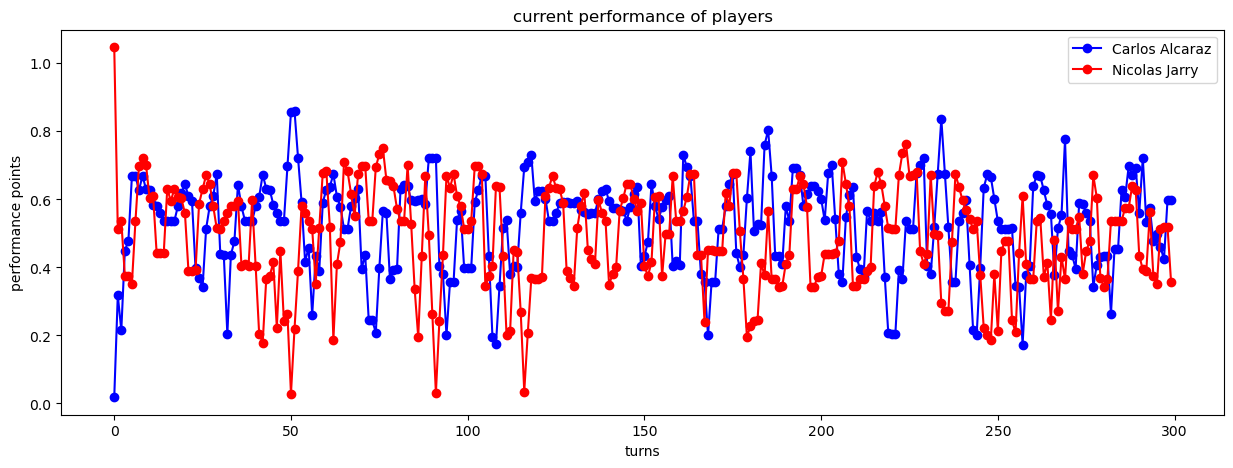

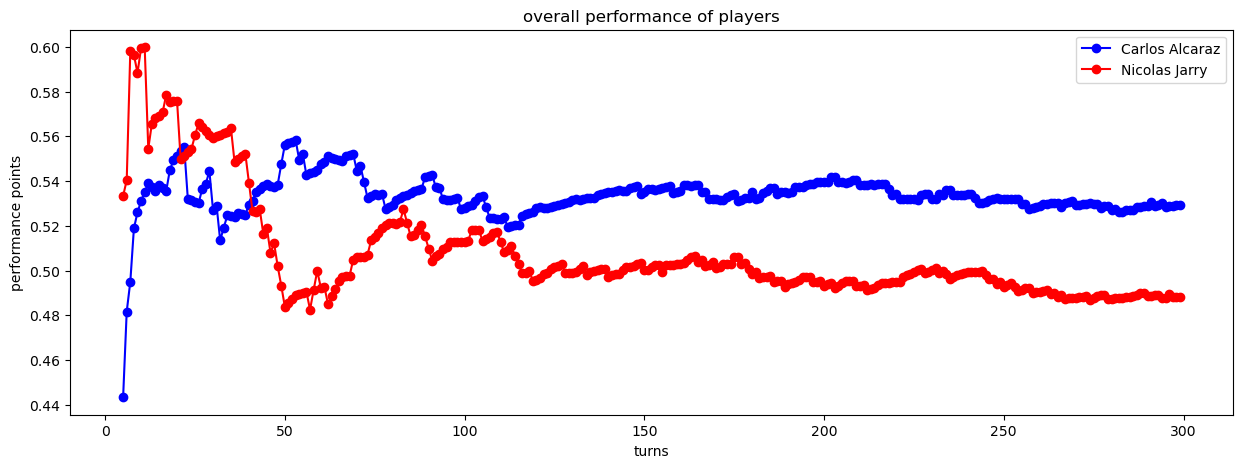

Accuracy: 0.8706
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       201
           1       0.92      0.82      0.86       201

    accuracy                           0.87       402
   macro avg       0.88      0.87      0.87       402
weighted avg       0.88      0.87      0.87       402

[[ 5.07314547e-01  5.52424938e+00 -5.91804978e-01 -5.99734664e+00
  -3.99603241e+00  1.17647023e+00  0.00000000e+00  7.75605039e+00
   3.31056899e-01  4.02682945e+00 -3.69577256e+00 -7.67674653e-03
   3.86424879e-01  3.11813408e-01  8.61304110e-01]]


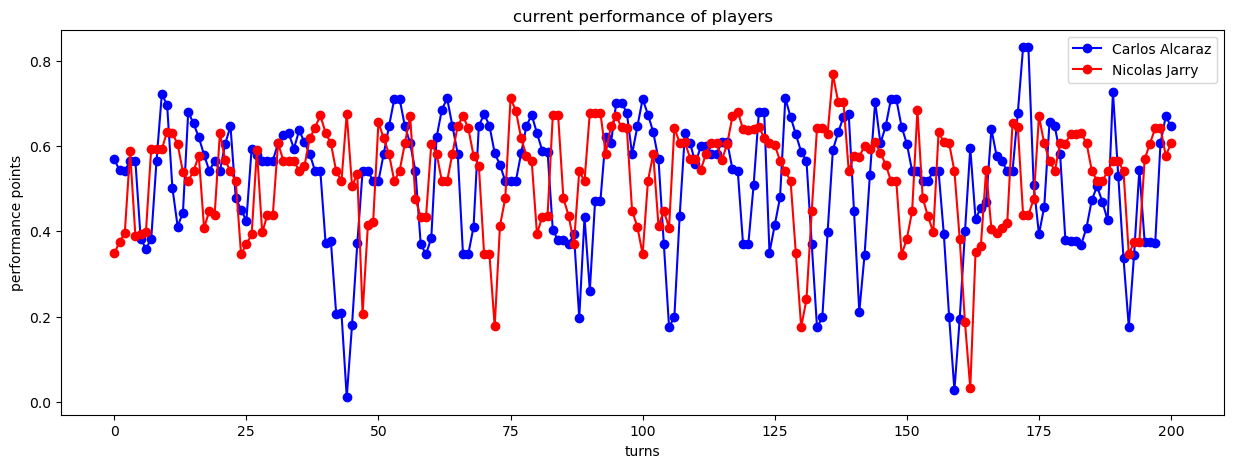

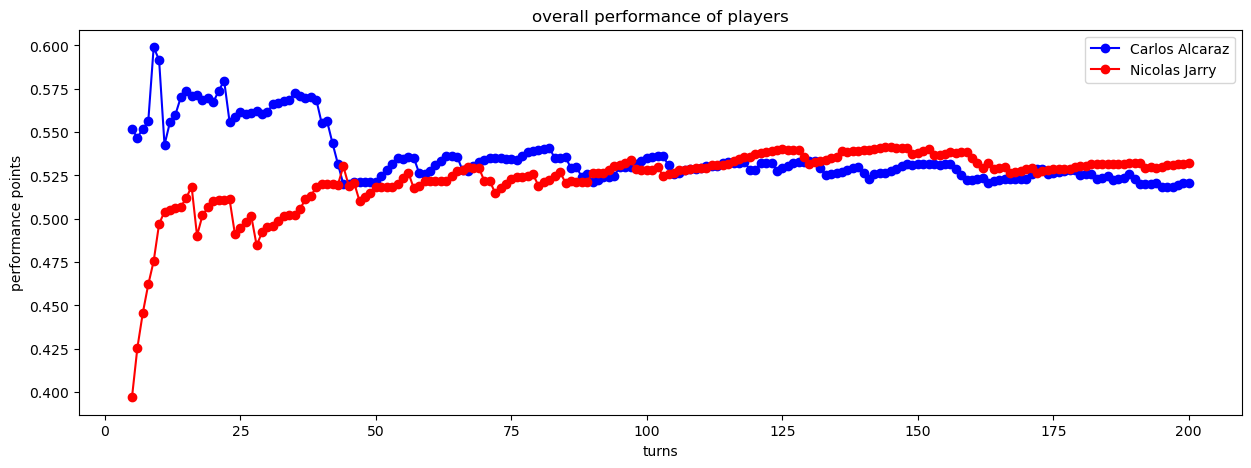

Accuracy: 0.8657
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       134
           1       0.92      0.80      0.86       134

    accuracy                           0.87       268
   macro avg       0.87      0.87      0.87       268
weighted avg       0.87      0.87      0.87       268

[[ 0.50823145  5.52274645 -0.58888209 -6.00764641 -3.97901654  1.16354936
   0.          7.74390517  0.32746542  4.01944726 -3.69198184  0.01995241
   0.41222476  0.30568864  0.88471746]]


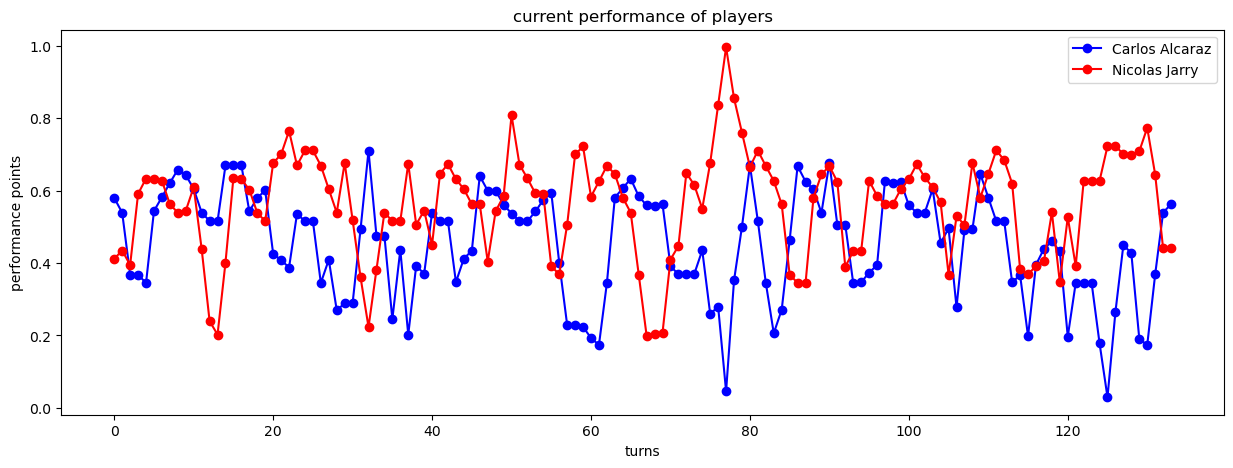

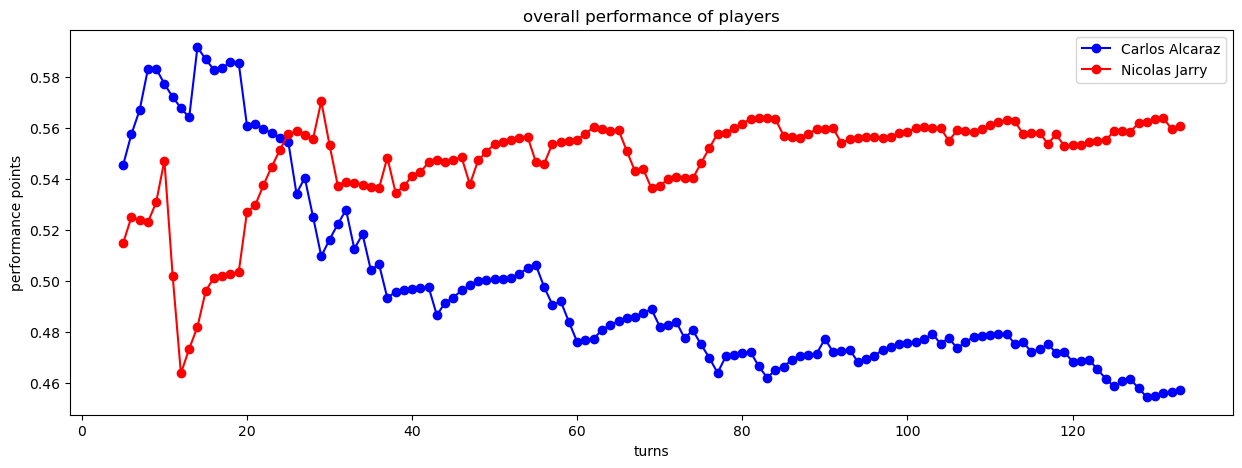

Accuracy: 0.8294
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       337
           1       0.87      0.78      0.82       337

    accuracy                           0.83       674
   macro avg       0.83      0.83      0.83       674
weighted avg       0.83      0.83      0.83       674

[[ 0.51656654  5.5053186  -0.59105145 -5.97350187 -3.97162331  1.19222842
   0.          7.71250354  0.34507188  3.99169552 -3.64662364  0.06801162
   0.38905884  0.32663621  0.87436794]]


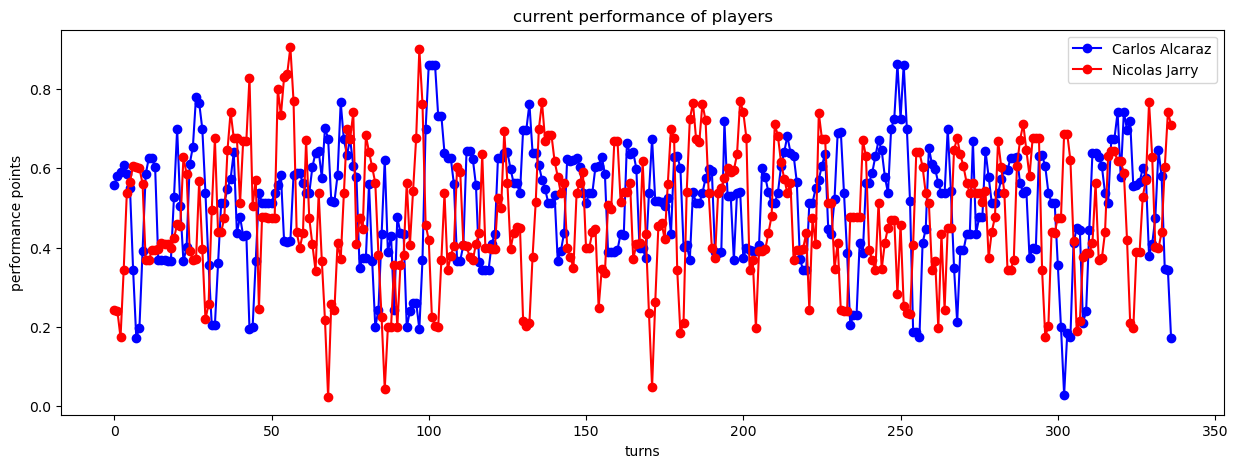

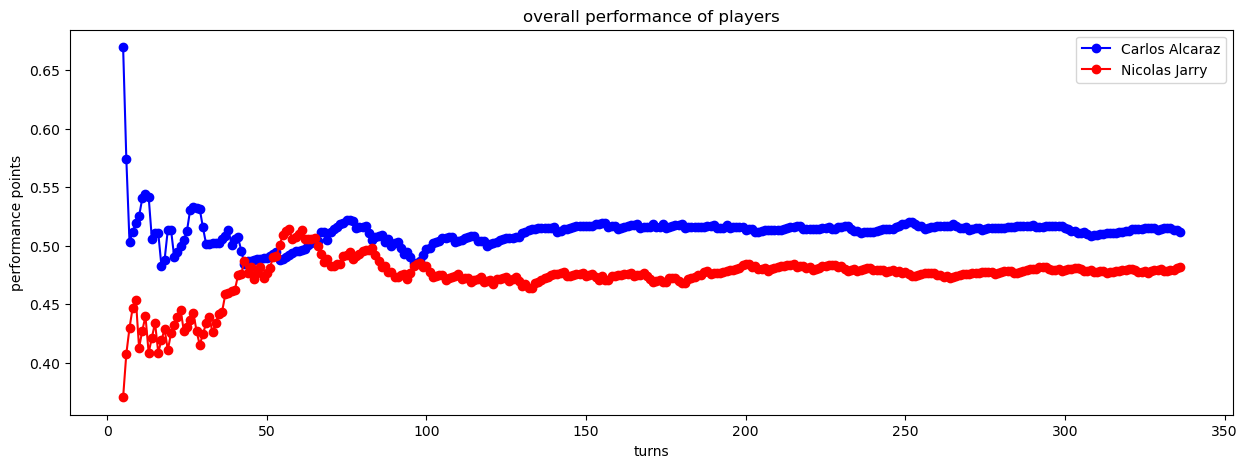

Accuracy: 0.8252
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       246
           1       0.87      0.76      0.81       246

    accuracy                           0.83       492
   macro avg       0.83      0.83      0.82       492
weighted avg       0.83      0.83      0.82       492

[[ 0.5160959   5.51076307 -0.59508682 -5.98997772 -3.98579442  1.1912609
   0.          7.75672712  0.33789917  4.02192066 -3.68402149  0.0262392
   0.41369963  0.3060495   0.86324778]]


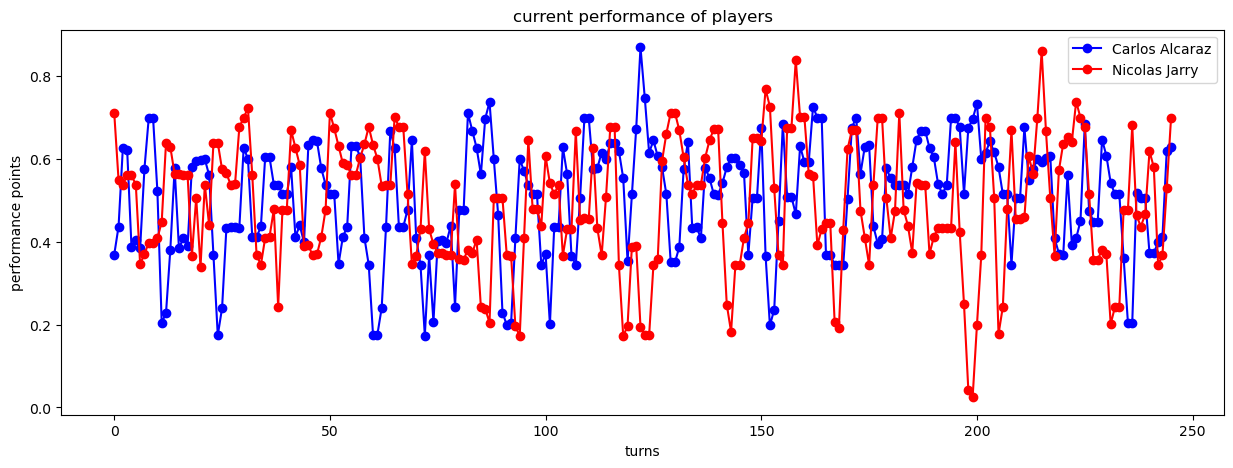

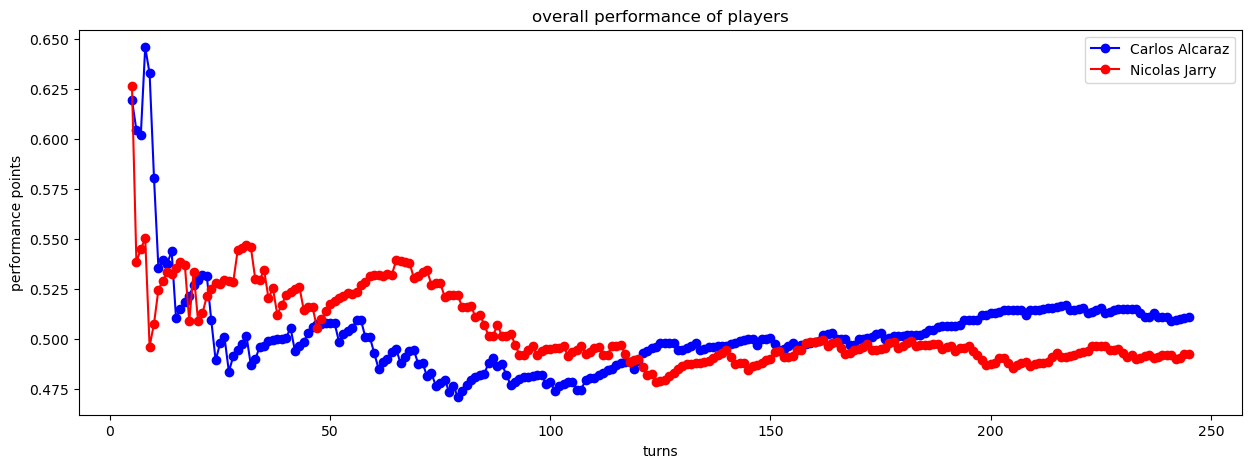

Accuracy: 0.8389
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       332
           1       0.86      0.80      0.83       332

    accuracy                           0.84       664
   macro avg       0.84      0.84      0.84       664
weighted avg       0.84      0.84      0.84       664

[[ 0.51221594  5.50514038 -0.58854788 -5.98822254 -3.98289734  1.14591169
   0.          7.71095398  0.32443934  4.00654175 -3.68210241  0.09203421
   0.41710986  0.28826037  0.8907271 ]]


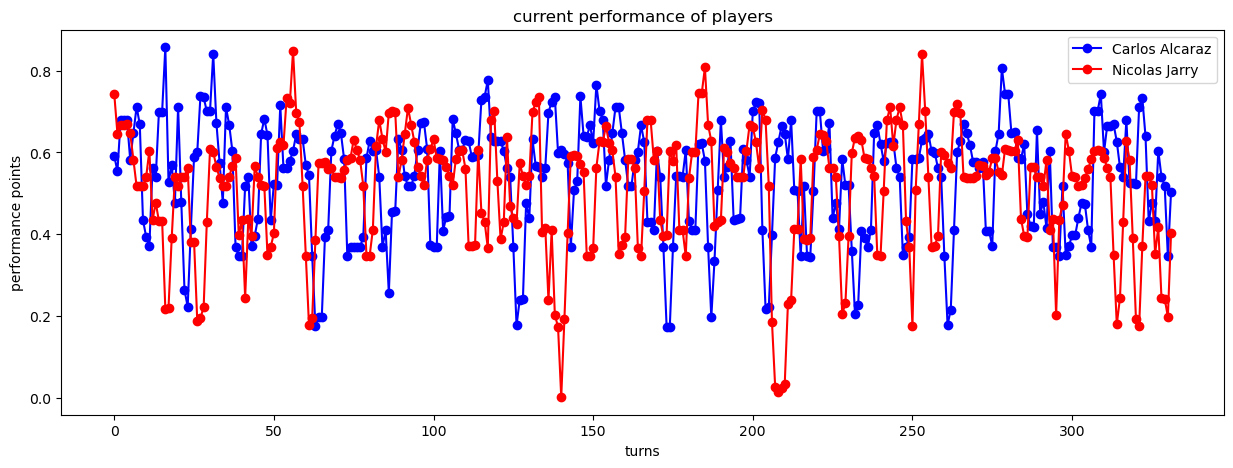

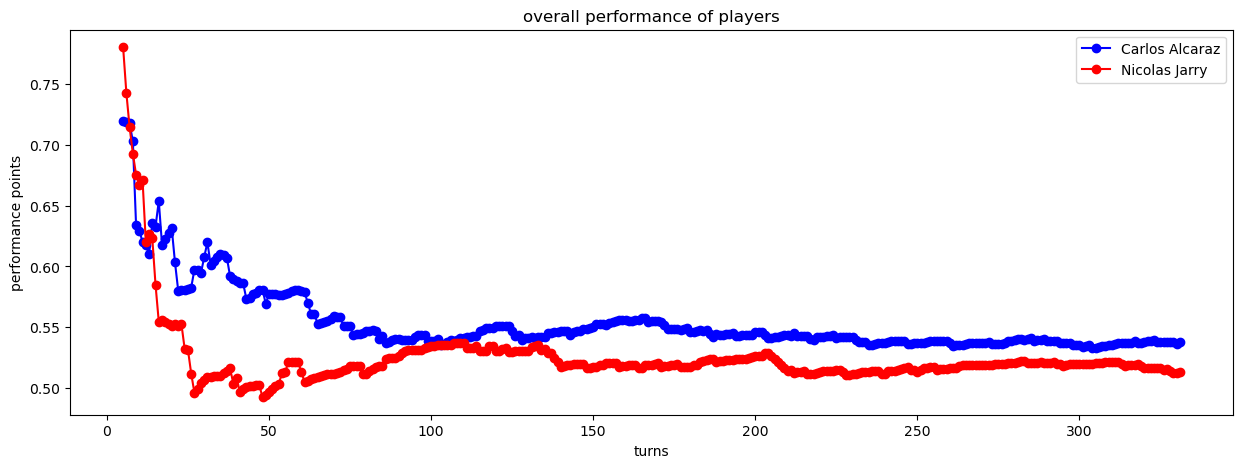

Accuracy: 0.8836
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.91      0.89       232
           1       0.90      0.86      0.88       232

    accuracy                           0.88       464
   macro avg       0.88      0.88      0.88       464
weighted avg       0.88      0.88      0.88       464

[[ 5.11152301e-01  5.49477546e+00 -5.82672988e-01 -6.01645599e+00
  -3.96364819e+00  1.15741045e+00  0.00000000e+00  7.70040847e+00
   3.26234202e-01  4.02247513e+00 -3.69624092e+00 -4.98199649e-03
   3.97006798e-01  3.08152653e-01  8.87582225e-01]]


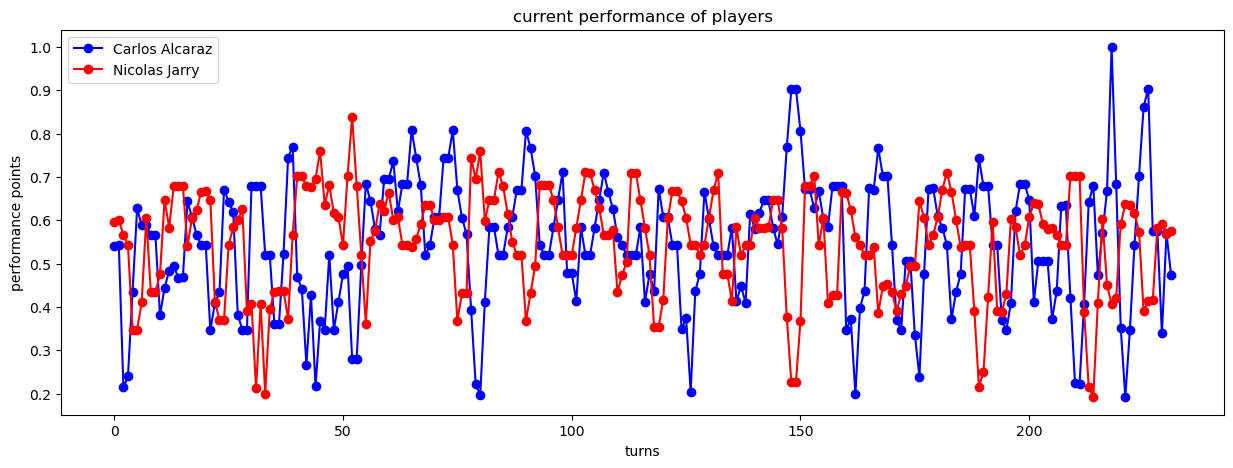

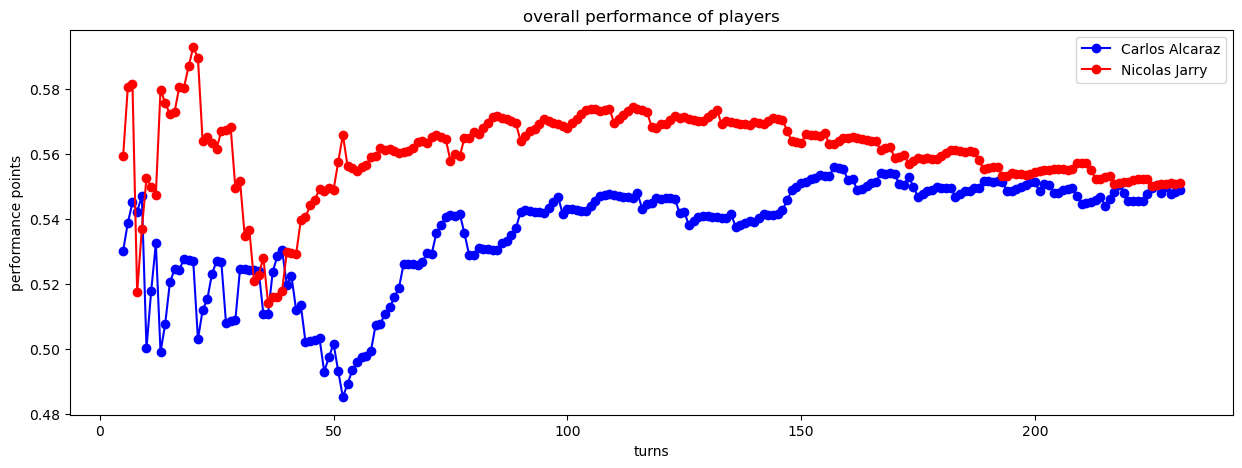

Accuracy: 0.8342
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       190
           1       0.86      0.80      0.83       190

    accuracy                           0.83       380
   macro avg       0.84      0.83      0.83       380
weighted avg       0.84      0.83      0.83       380

[[ 0.51116356  5.51512808 -0.58461622 -6.011126   -4.01240899  1.1646047
   0.          7.77399896  0.32589622  4.01688127 -3.69098505  0.0378917
   0.40488941  0.31056336  0.889713  ]]


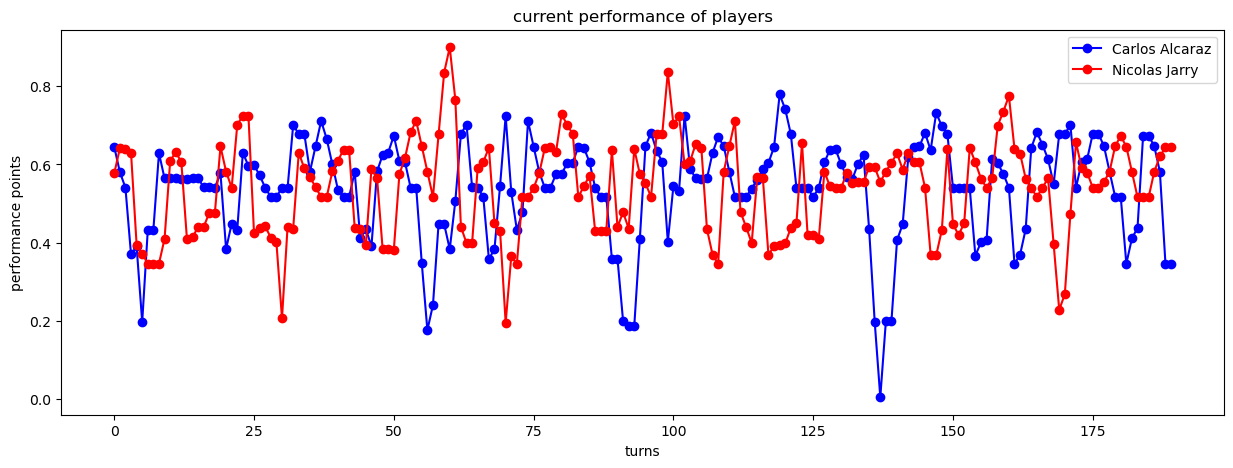

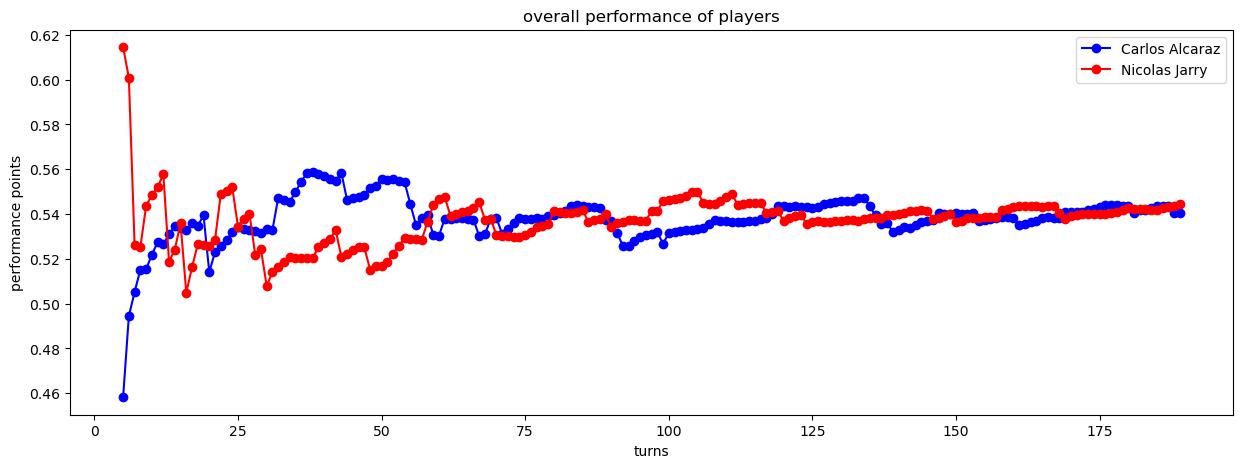

Accuracy: 0.8192
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.86      0.83       213
           1       0.85      0.77      0.81       213

    accuracy                           0.82       426
   macro avg       0.82      0.82      0.82       426
weighted avg       0.82      0.82      0.82       426

[[ 0.50679687  5.51731596 -0.57596487 -6.00503857 -4.01830898  1.17666082
   0.          7.78834673  0.32785059  4.00247245 -3.67462186  0.08386201
   0.42538499  0.31968116  0.87952499]]


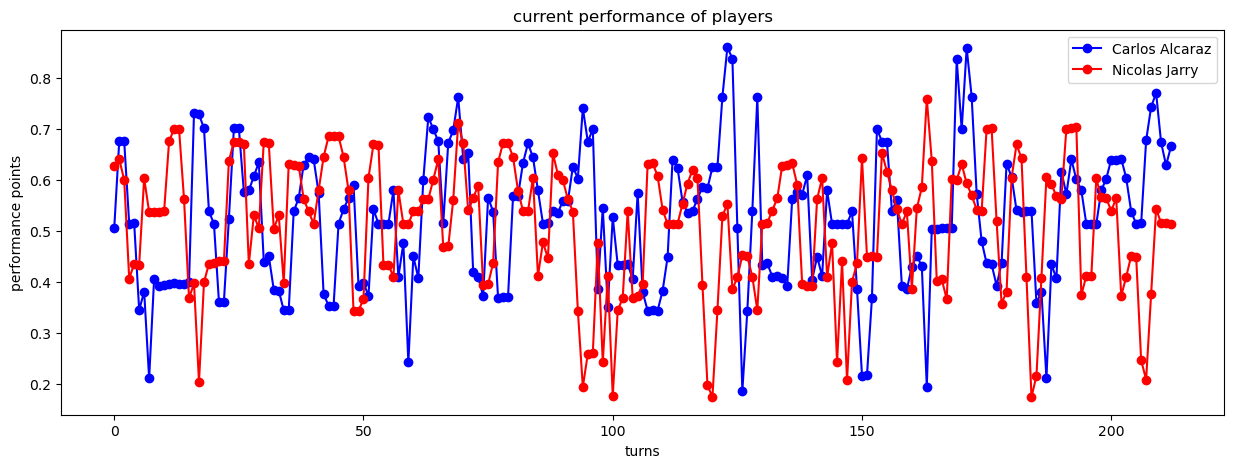

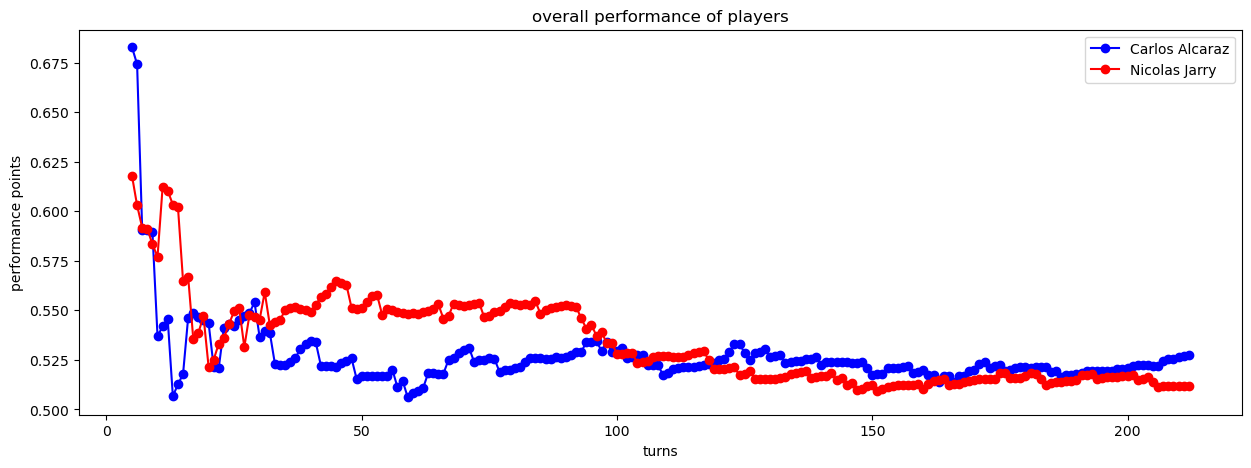

Accuracy: 0.7170
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.94      0.77       318
           1       0.90      0.49      0.63       318

    accuracy                           0.72       636
   macro avg       0.77      0.72      0.70       636
weighted avg       0.77      0.72      0.70       636

[[ 0.50594432  5.50496829 -0.49321439 -5.97097465 -4.02962596  0.8824833
   0.          7.76853676  0.32598698  3.97406143 -3.64807445  0.07861194
   0.42440395  0.32225397  1.28656946]]


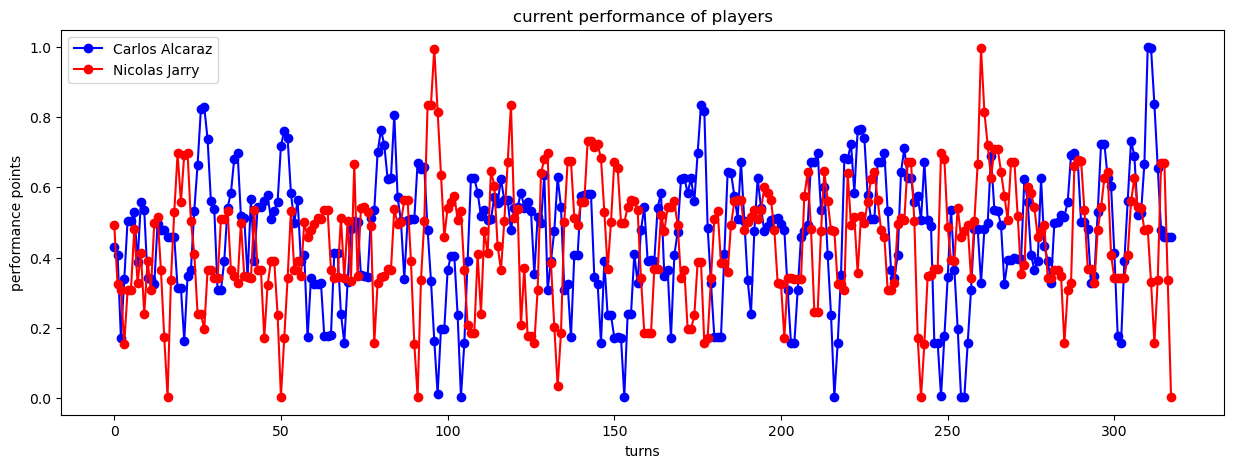

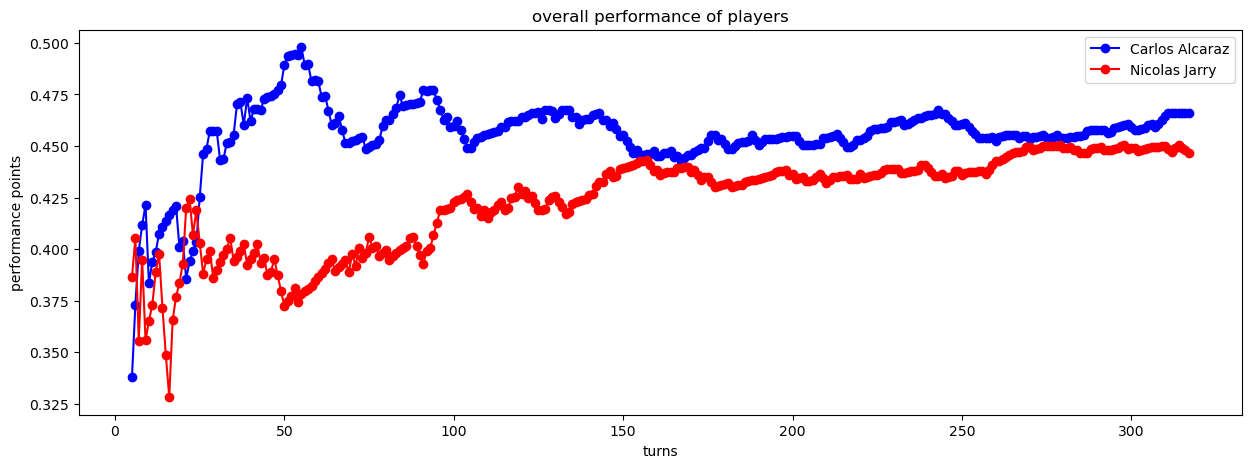

Accuracy: 0.8059
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       170
           1       0.81      0.81      0.81       170

    accuracy                           0.81       340
   macro avg       0.81      0.81      0.81       340
weighted avg       0.81      0.81      0.81       340

[[ 0.49897304  5.51454103 -0.56365788 -6.01358756 -4.02208058  1.10576794
   0.          7.78299486  0.33150457  4.01763556 -3.68613099  0.05863482
   0.40064912  0.29673584  0.97056894]]


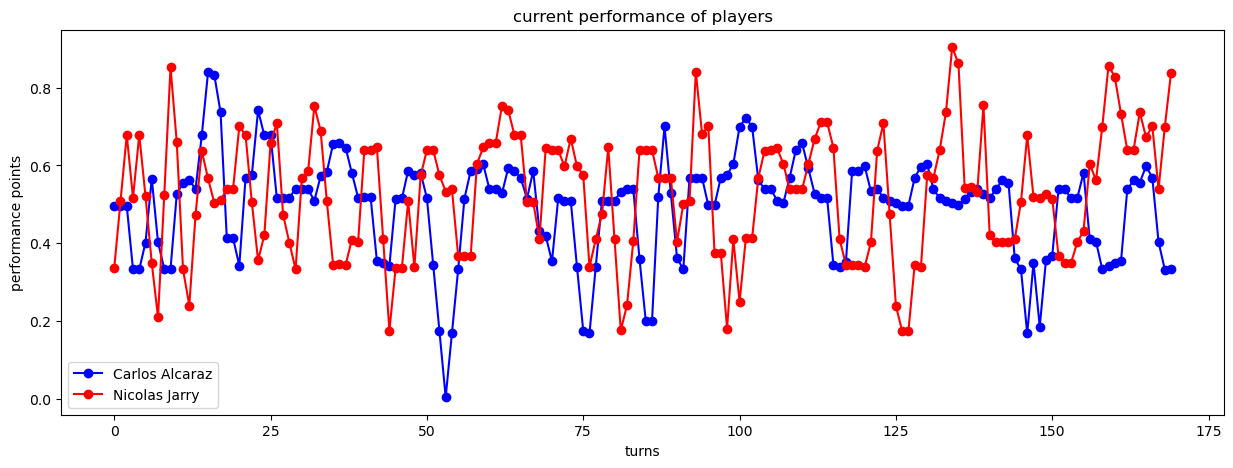

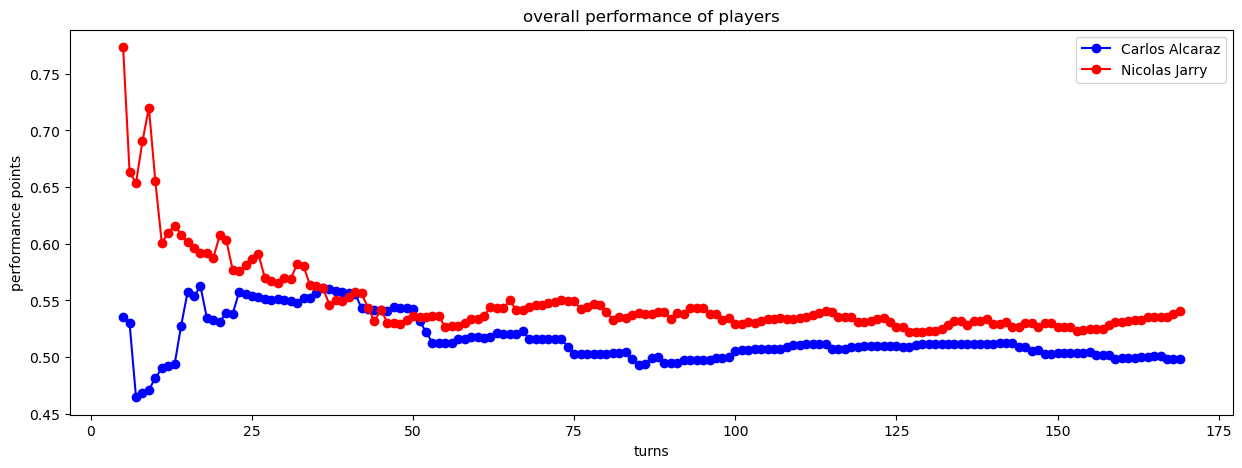

Accuracy: 0.7873
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.87      0.80       275
           1       0.85      0.70      0.77       275

    accuracy                           0.79       550
   macro avg       0.80      0.79      0.79       550
weighted avg       0.80      0.79      0.79       550

[[ 0.50926976  5.52457621 -0.58415843 -5.97051116 -4.01097227  1.19881717
   0.          7.75912552  0.33854607  3.97863621 -3.64009014  0.0634211
   0.4171046   0.32561962  0.88944417]]


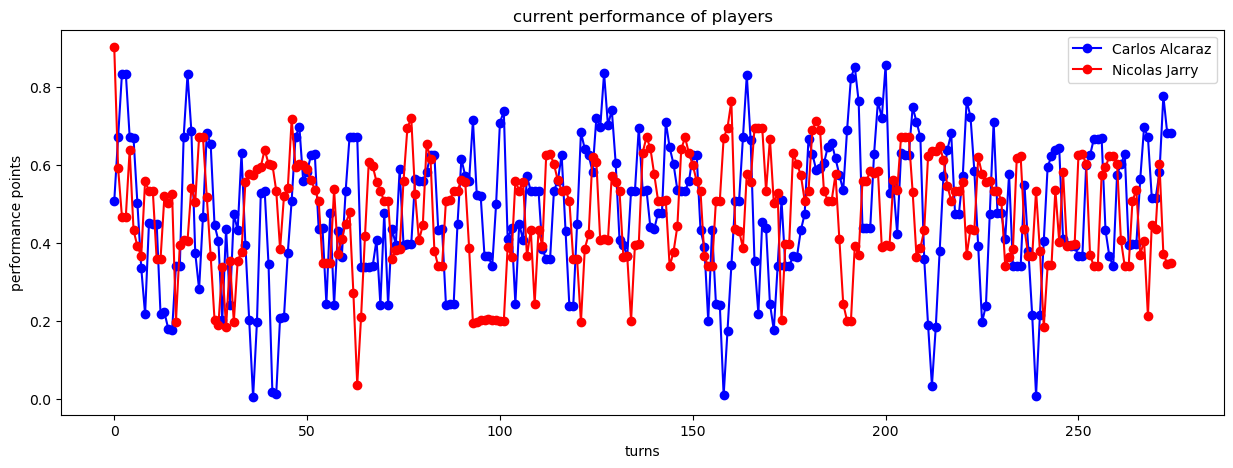

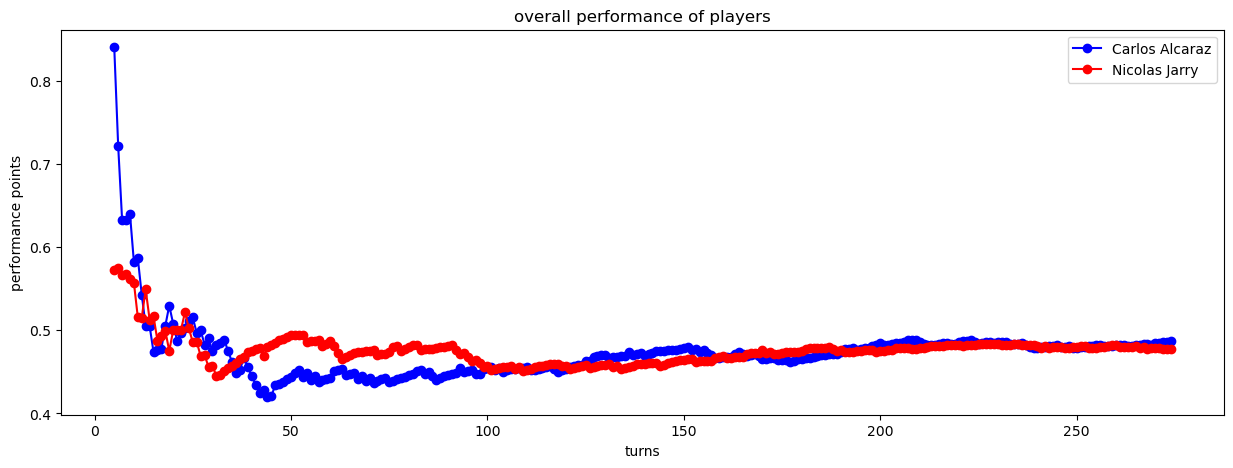

Accuracy: 0.7672
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.78      0.77       290
           1       0.77      0.76      0.76       290

    accuracy                           0.77       580
   macro avg       0.77      0.77      0.77       580
weighted avg       0.77      0.77      0.77       580

[[ 0.50955582  5.5027138  -0.59549129 -6.014135   -4.03577515  1.19287487
   0.          7.80081045  0.34157591  4.01050579 -3.66892988  0.08146792
   0.43458629  0.28897168  0.88600166]]


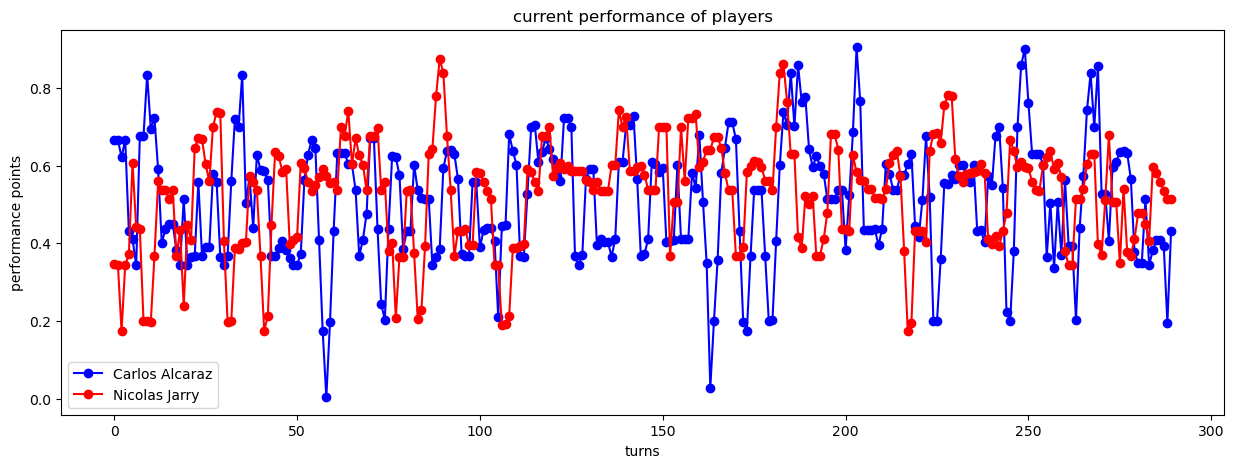

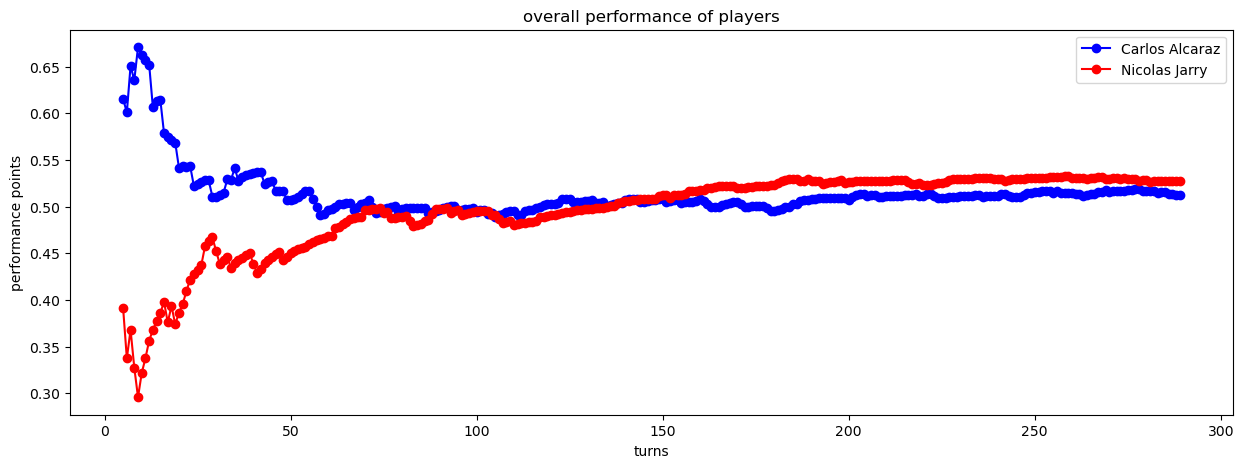

Accuracy: 0.8378
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       185
           1       0.90      0.76      0.82       185

    accuracy                           0.84       370
   macro avg       0.85      0.84      0.84       370
weighted avg       0.85      0.84      0.84       370

[[ 0.50756555  5.53062386 -0.5832686  -5.99556345 -4.00562742  1.17216396
   0.          7.7844522   0.33992802  4.0215595  -3.68163148  0.07775959
   0.41624785  0.31332952  0.88029767]]


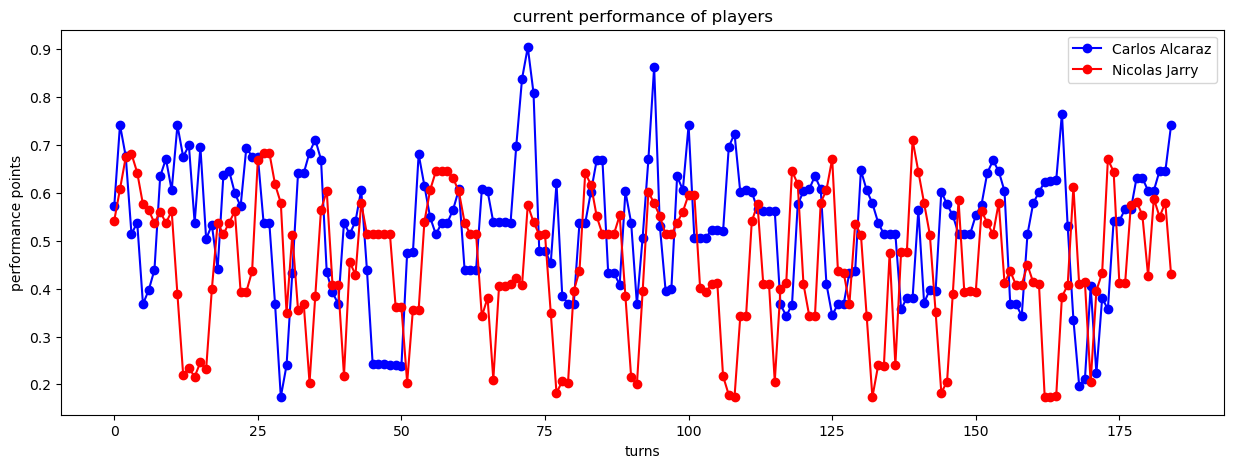

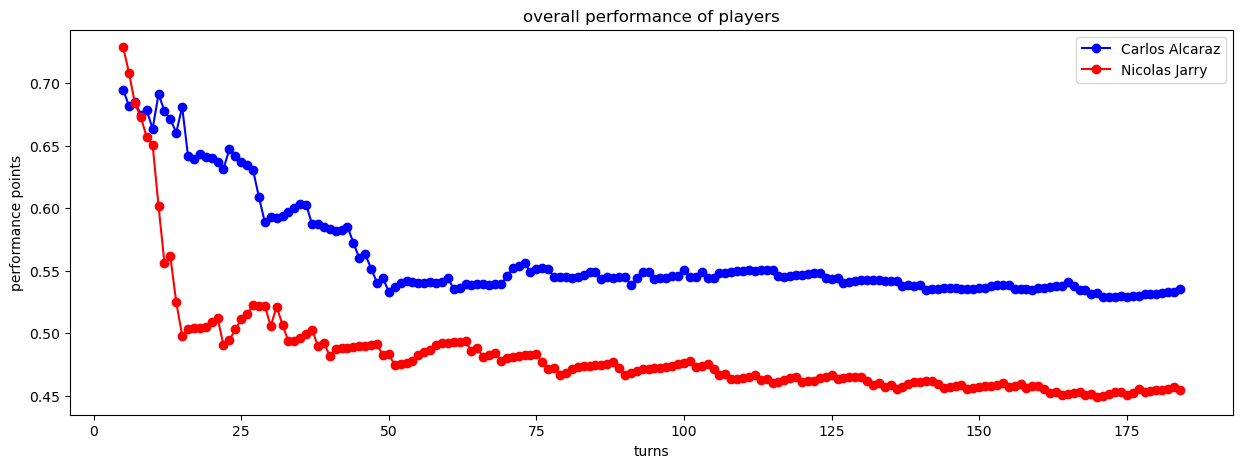

Accuracy: 0.8434
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       198
           1       0.85      0.83      0.84       198

    accuracy                           0.84       396
   macro avg       0.84      0.84      0.84       396
weighted avg       0.84      0.84      0.84       396

[[ 0.50968304  5.51603953 -0.57105233 -6.0162181  -4.0095777   1.16093336
   0.          7.73224917  0.33075076  4.01859549 -3.68784473  0.12341271
   0.40501259  0.32398193  0.89977422]]


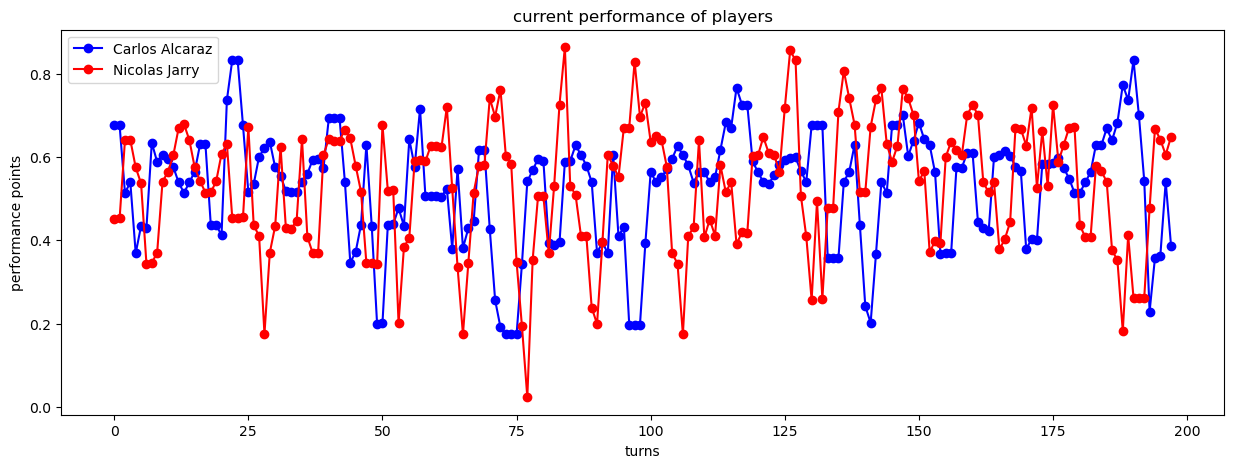

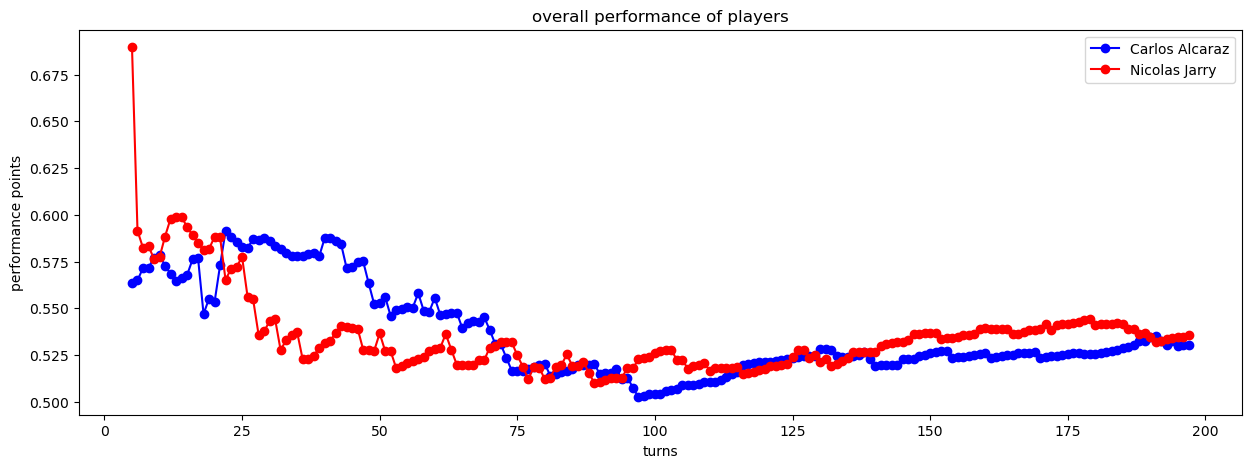

Accuracy: 0.8263
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       167
           1       0.86      0.78      0.82       167

    accuracy                           0.83       334
   macro avg       0.83      0.83      0.83       334
weighted avg       0.83      0.83      0.83       334

[[ 0.51264169  5.530843   -0.59197686 -5.99690632 -3.99997704  1.18251001
   0.          7.76921703  0.33048137  4.0223004  -3.69181903  0.01566217
   0.37549382  0.31164915  0.88364416]]


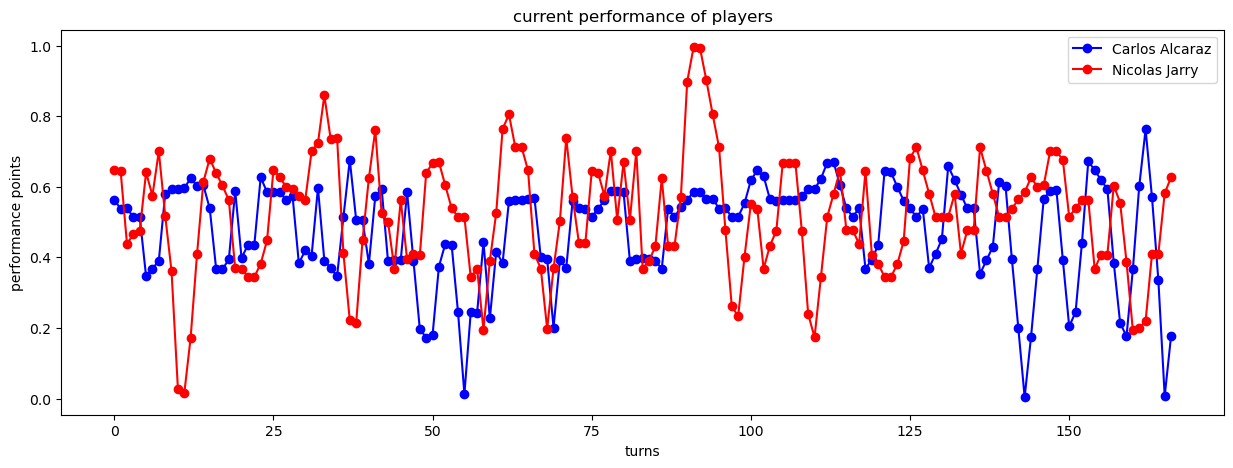

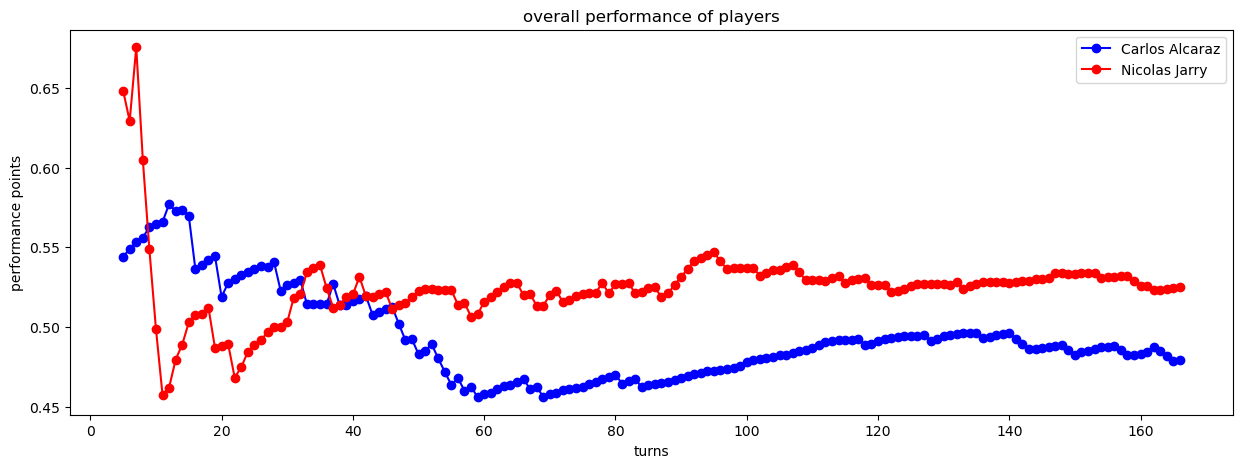

Accuracy: 0.8156
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.87      0.83       225
           1       0.85      0.76      0.80       225

    accuracy                           0.82       450
   macro avg       0.82      0.82      0.81       450
weighted avg       0.82      0.82      0.81       450

[[ 0.50936542  5.51576232 -0.58006372 -6.00195772 -4.0058079   1.16709007
   0.          7.75791685  0.34041561  4.01246193 -3.67204633  0.0548294
   0.39905245  0.31708541  0.90803386]]


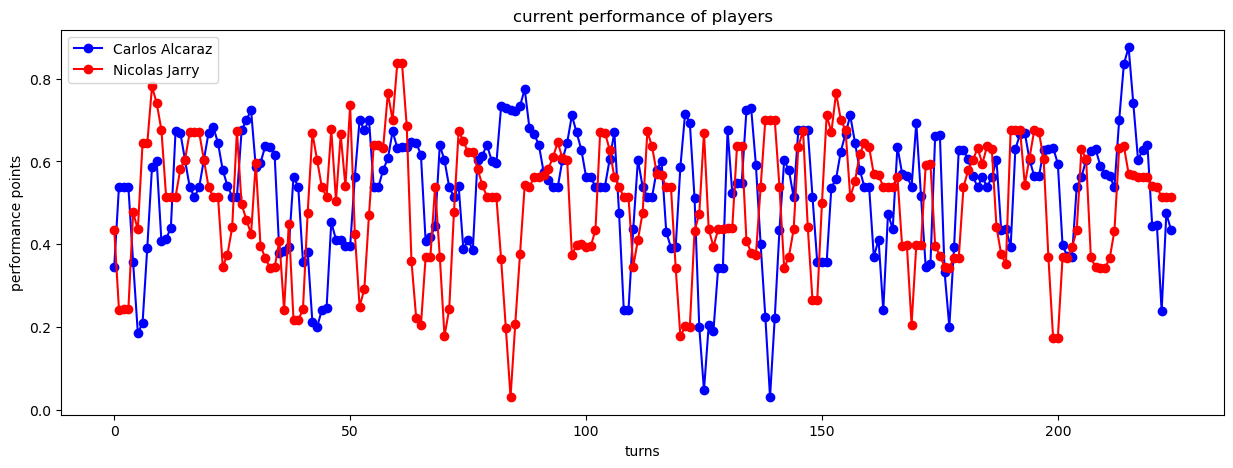

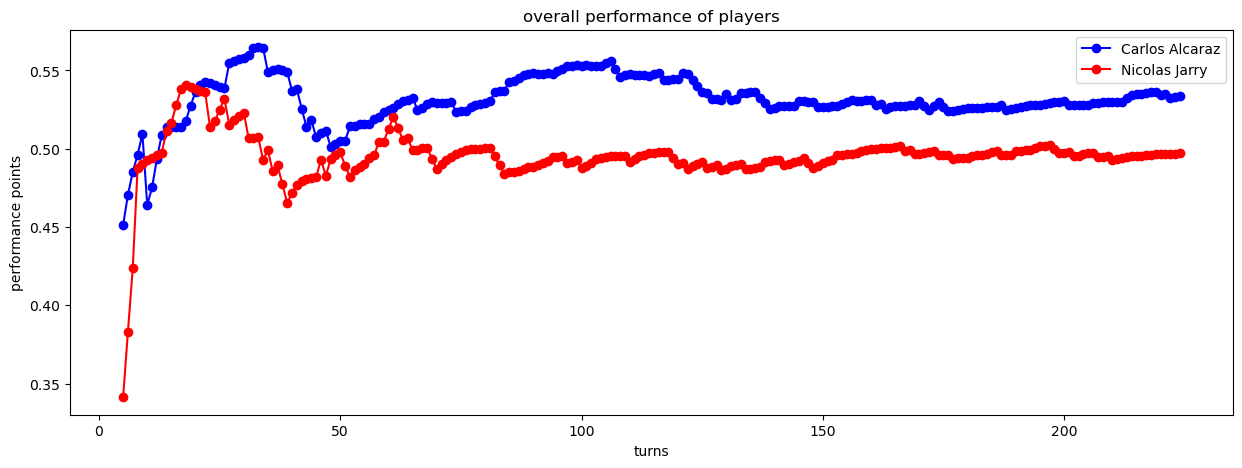

Accuracy: 0.8285
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.84       274
           1       0.86      0.79      0.82       274

    accuracy                           0.83       548
   macro avg       0.83      0.83      0.83       548
weighted avg       0.83      0.83      0.83       548

[[ 0.51036652  5.5125356  -0.57553781 -6.0005193  -3.99832783  1.18407254
   0.          7.74461103  0.32994892  4.01246145 -3.68251253 -0.03396785
   0.38199941  0.30265574  0.87537297]]


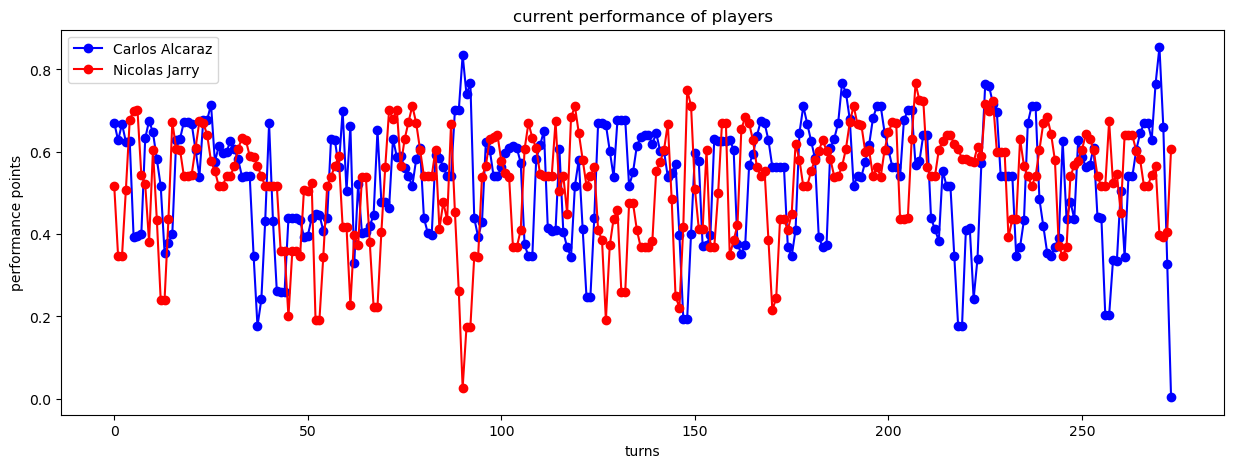

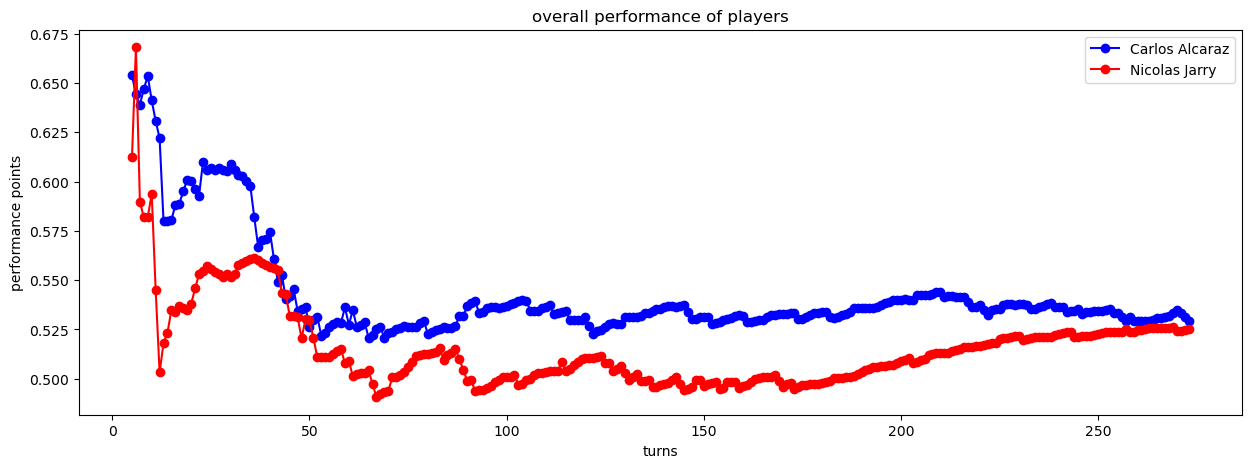

Accuracy: 0.8238
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.95      0.84       122
           1       0.93      0.70      0.80       122

    accuracy                           0.82       244
   macro avg       0.85      0.82      0.82       244
weighted avg       0.85      0.82      0.82       244

[[ 0.50348679  5.54310397 -0.58988786 -5.99787502 -3.99812757  1.18107073
   0.          7.78170782  0.34335516  4.01758395 -3.67422878 -0.01515469
   0.40470732  0.31805857  0.88480638]]


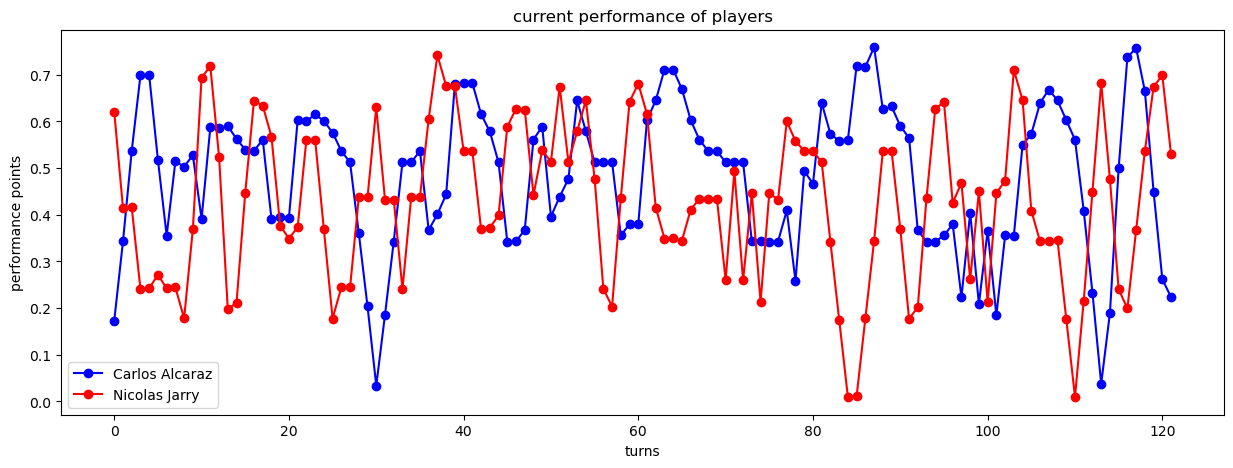

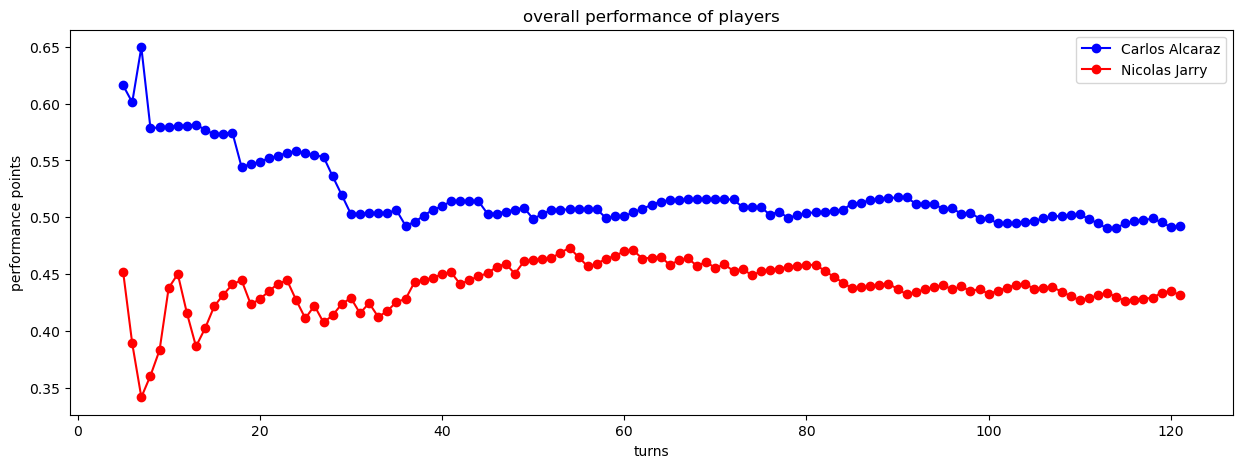

Accuracy: 0.8531
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       286
           1       0.89      0.80      0.85       286

    accuracy                           0.85       572
   macro avg       0.86      0.85      0.85       572
weighted avg       0.86      0.85      0.85       572

[[ 0.5112893   5.5059769  -0.59713    -5.99638972 -3.97241832  1.16258111
   0.          7.71387396  0.32984651  4.0019888  -3.67214229  0.05351008
   0.44903847  0.31851948  0.87625648]]


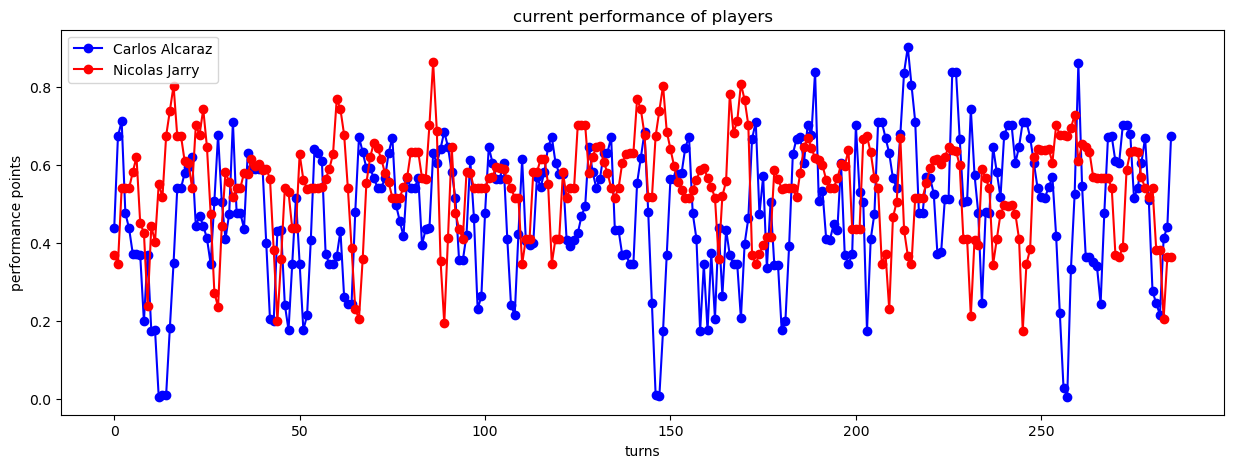

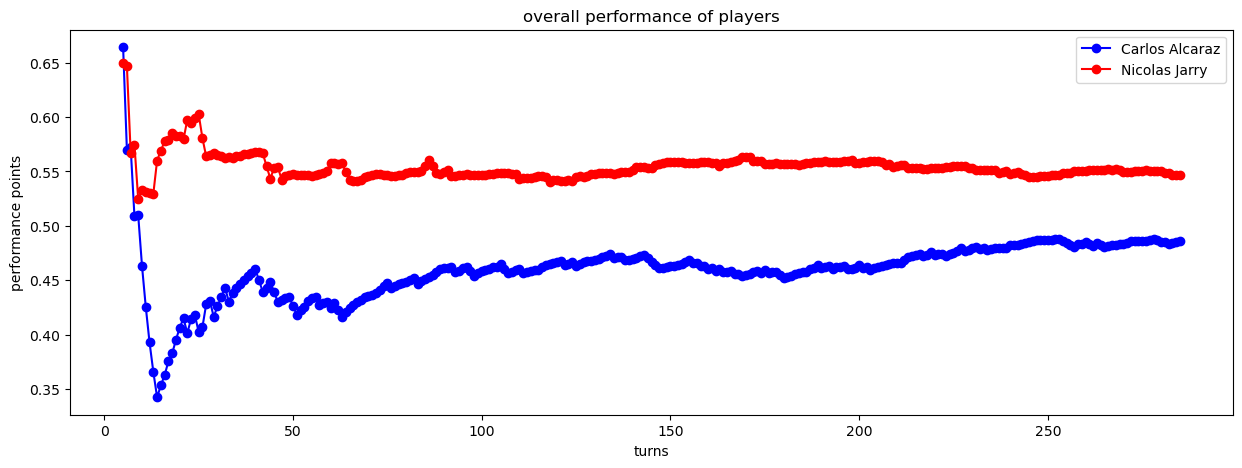

Accuracy: 0.8023
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.81      0.80       215
           1       0.81      0.79      0.80       215

    accuracy                           0.80       430
   macro avg       0.80      0.80      0.80       430
weighted avg       0.80      0.80      0.80       430

[[ 0.50668333  5.51073402 -0.588992   -6.01563271 -4.01785671  1.19081544
   0.          7.7695851   0.34869699  4.01519508 -3.66649809  0.05694788
   0.40103591  0.31188485  0.88401017]]


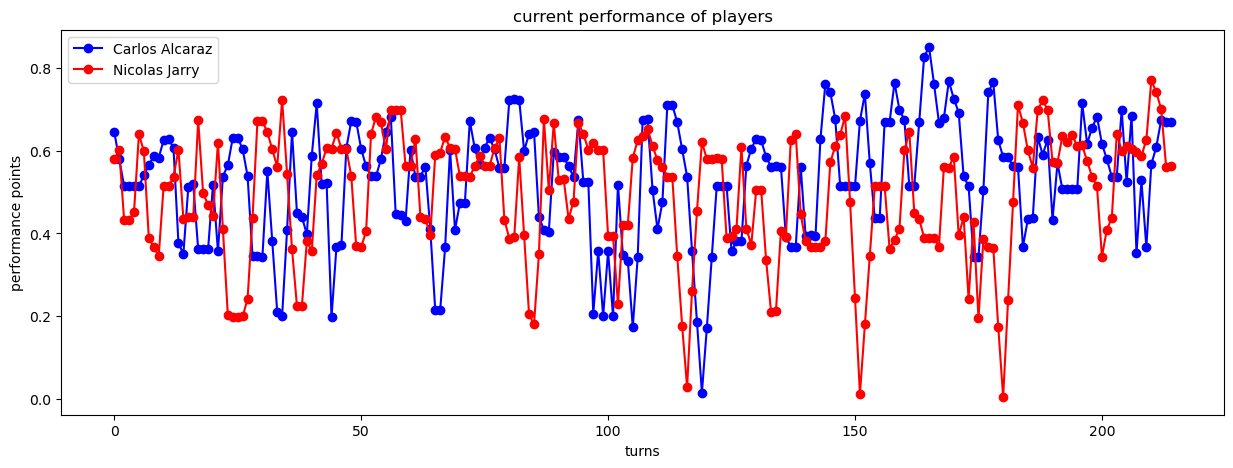

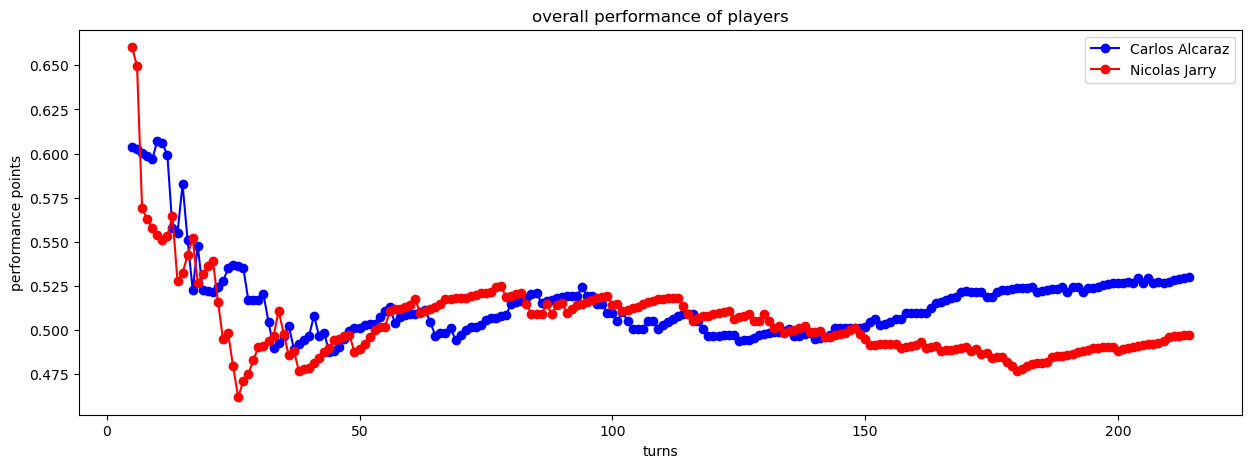

Accuracy: 0.8308
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       195
           1       0.87      0.78      0.82       195

    accuracy                           0.83       390
   macro avg       0.83      0.83      0.83       390
weighted avg       0.83      0.83      0.83       390

[[ 0.50840085  5.52041069 -0.58061178 -6.00043312 -4.01099331  1.16166032
   0.          7.77959944  0.32509337  4.01052461 -3.68543124  0.06460548
   0.43185496  0.32121251  0.89689171]]


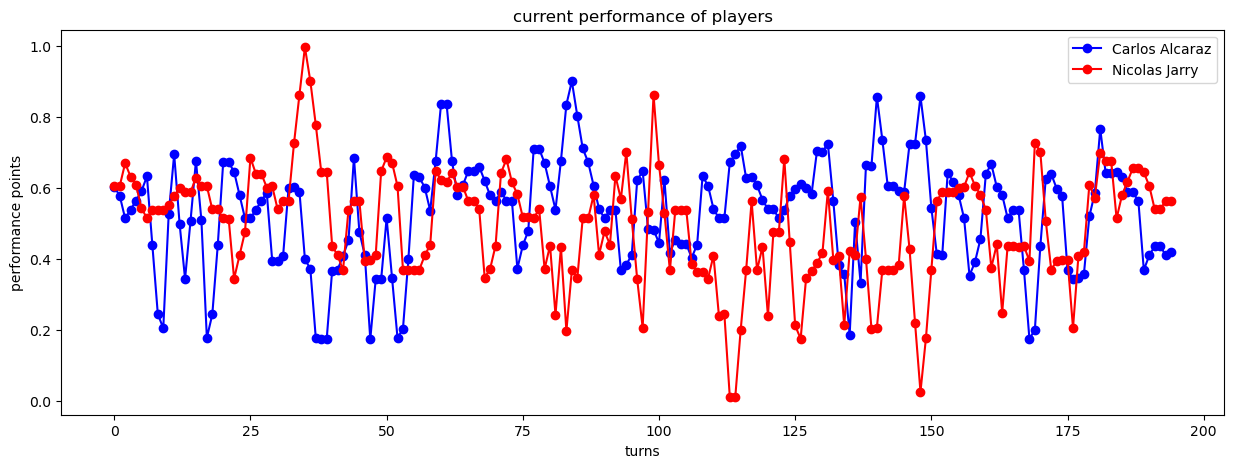

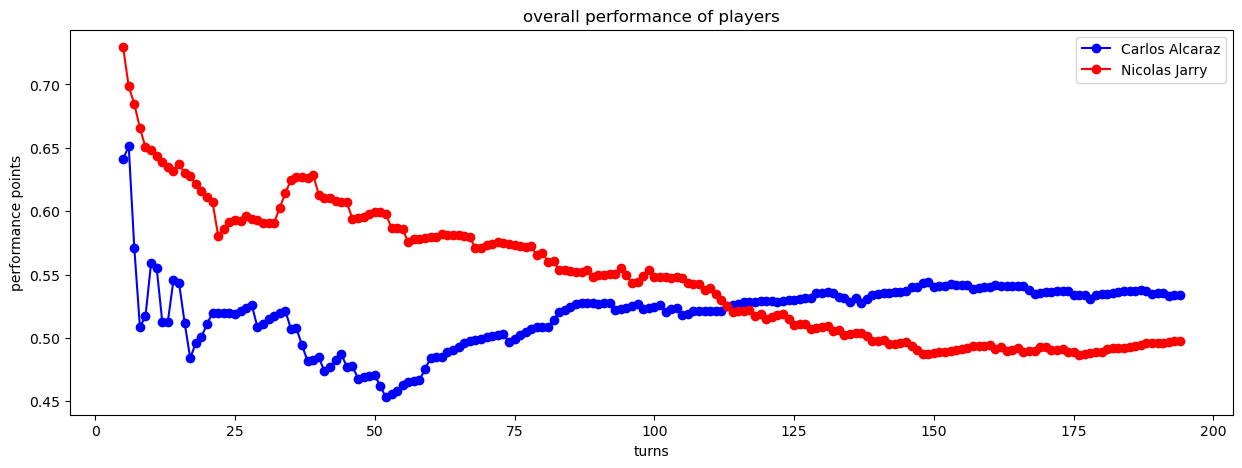

Accuracy: 0.8474
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       331
           1       0.87      0.82      0.84       331

    accuracy                           0.85       662
   macro avg       0.85      0.85      0.85       662
weighted avg       0.85      0.85      0.85       662

[[ 0.49323807  5.49607855 -0.57869519 -6.00526407 -4.0060923   1.14058837
   0.          7.7392536   0.3318308   4.01074993 -3.67891913  0.03500336
   0.44812274  0.32238141  0.90739374]]


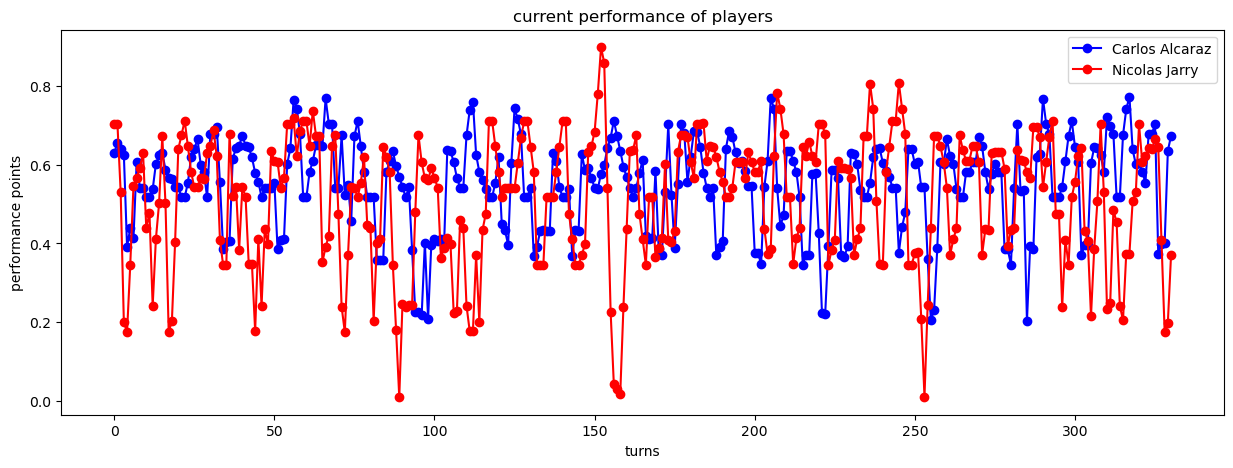

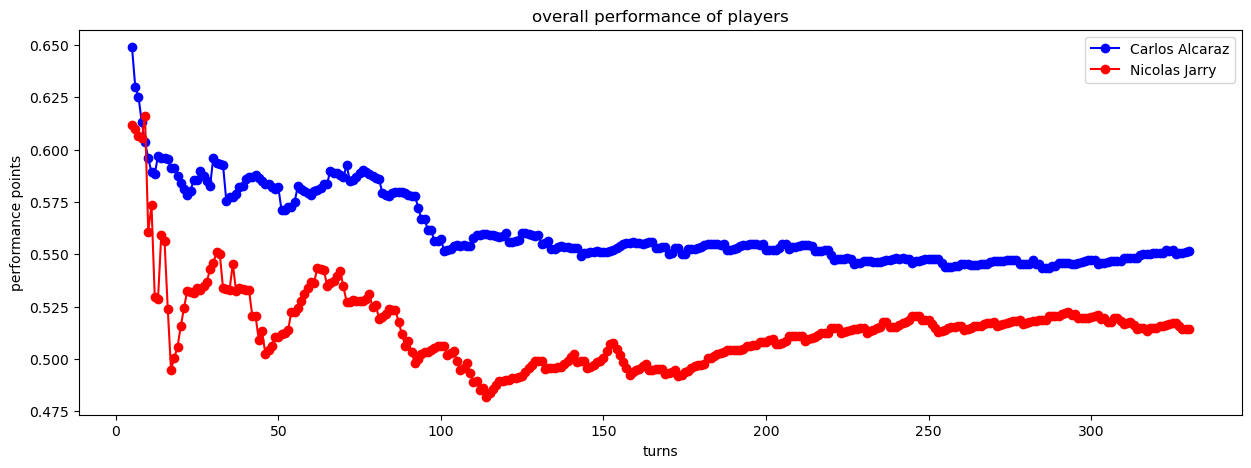

Accuracy: 0.8727
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       271
           1       0.91      0.83      0.87       271

    accuracy                           0.87       542
   macro avg       0.88      0.87      0.87       542
weighted avg       0.88      0.87      0.87       542

[[ 0.50000397  5.50811999 -0.58740276 -6.00350641 -3.98462601  1.14202299
   0.          7.71888961  0.33214349  4.01957117 -3.68742767  0.06949196
   0.42143253  0.30175695  0.88820585]]


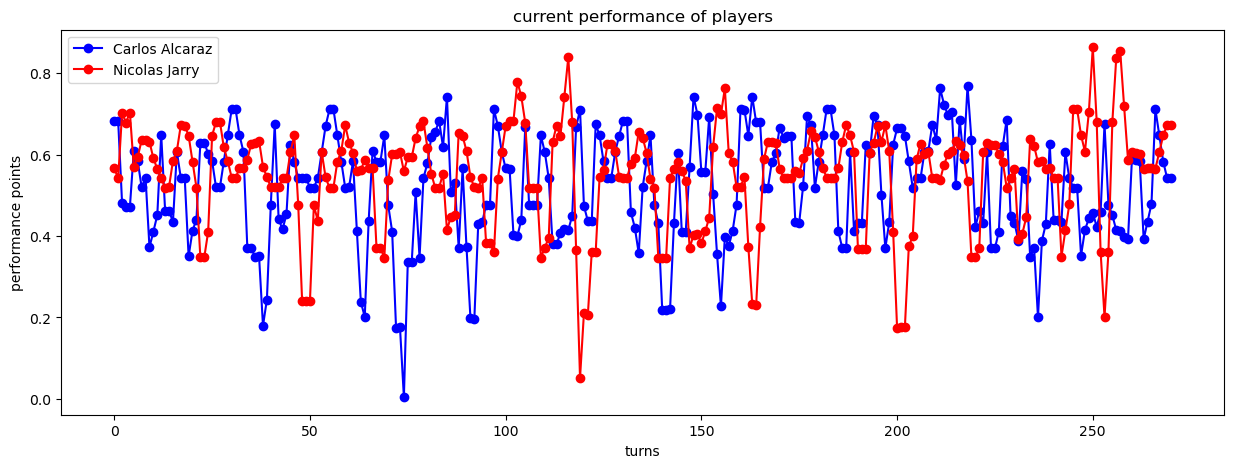

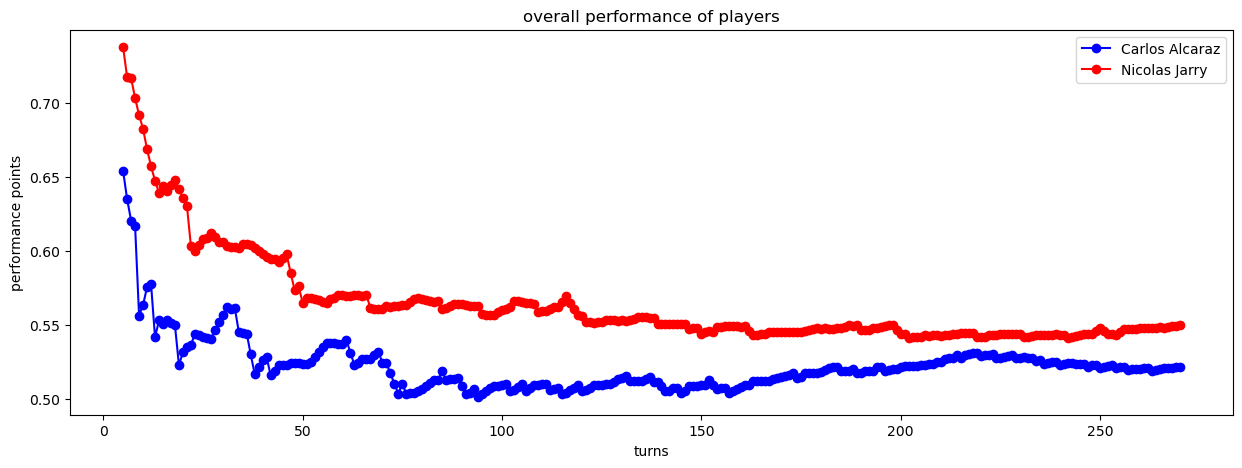

Accuracy: 0.8413
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.84       189
           1       0.84      0.84      0.84       189

    accuracy                           0.84       378
   macro avg       0.84      0.84      0.84       378
weighted avg       0.84      0.84      0.84       378

[[ 0.5212789   5.50943644 -0.57984881 -6.01753872 -4.00954804  1.16454493
   0.          7.73475663  0.32897655  4.02777848 -3.69880193  0.06225441
   0.39874958  0.31640998  0.89751362]]


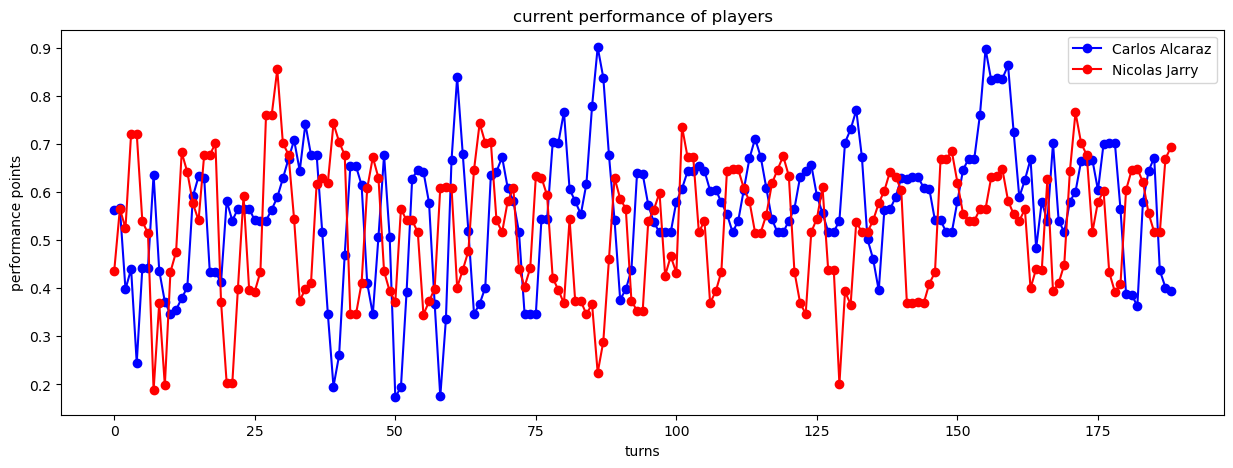

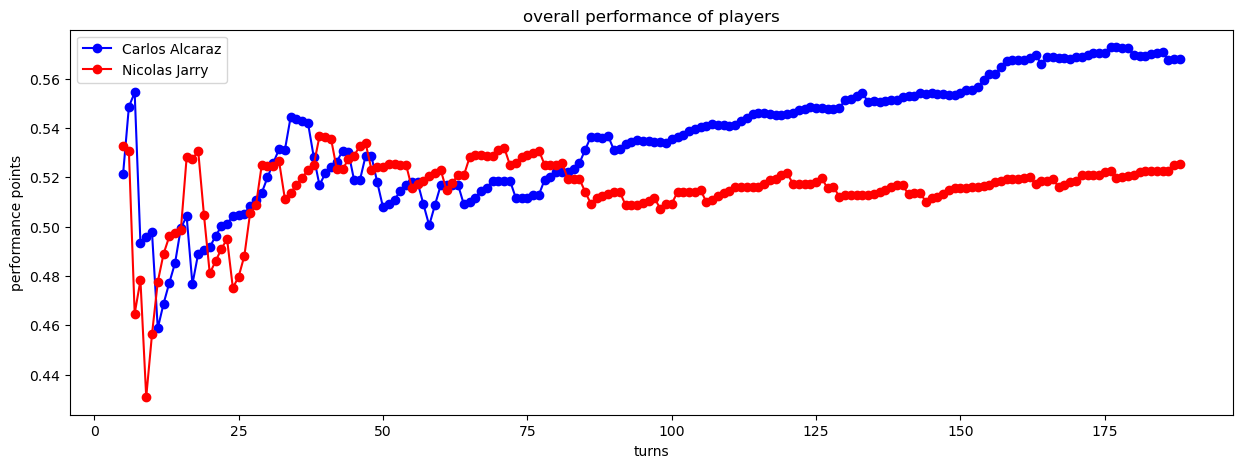

Accuracy: 0.8445
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       283
           1       0.88      0.80      0.84       283

    accuracy                           0.84       566
   macro avg       0.85      0.84      0.84       566
weighted avg       0.85      0.84      0.84       566

[[ 0.49889616  5.49803449 -0.56896185 -5.99869332 -3.97902283  1.17007621
   0.          7.73425663  0.32361854  4.00165789 -3.67803935  0.0351962
   0.39104963  0.32398332  0.90117247]]


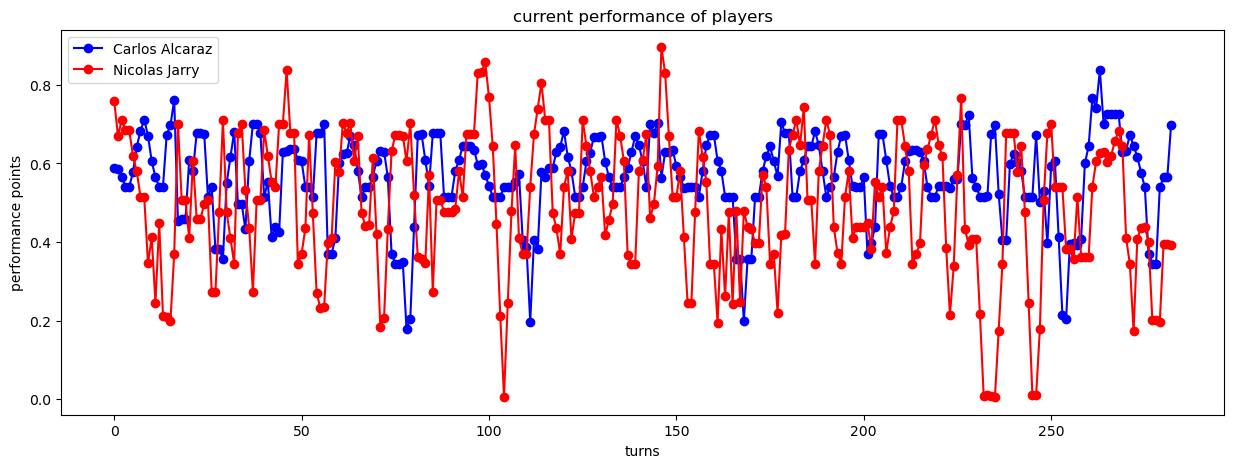

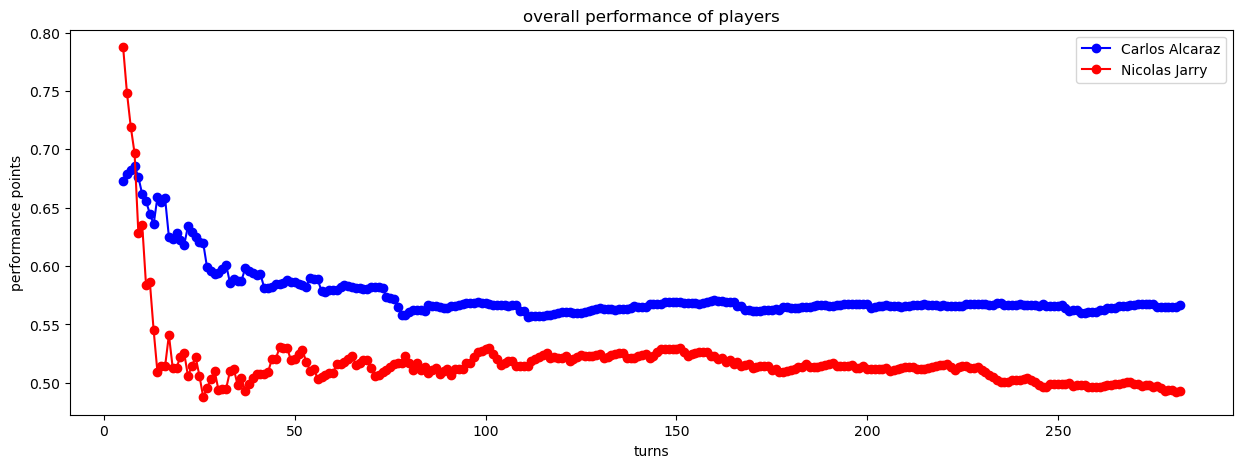

Accuracy: 0.8109
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       193
           1       0.83      0.79      0.81       193

    accuracy                           0.81       386
   macro avg       0.81      0.81      0.81       386
weighted avg       0.81      0.81      0.81       386

[[ 0.50527259  5.51816762 -0.58031302 -6.01230618 -4.02136279  1.16357007
   0.          7.77483093  0.32722801  3.99762836 -3.67040035  0.06155789
   0.42519478  0.30742429  0.90622754]]


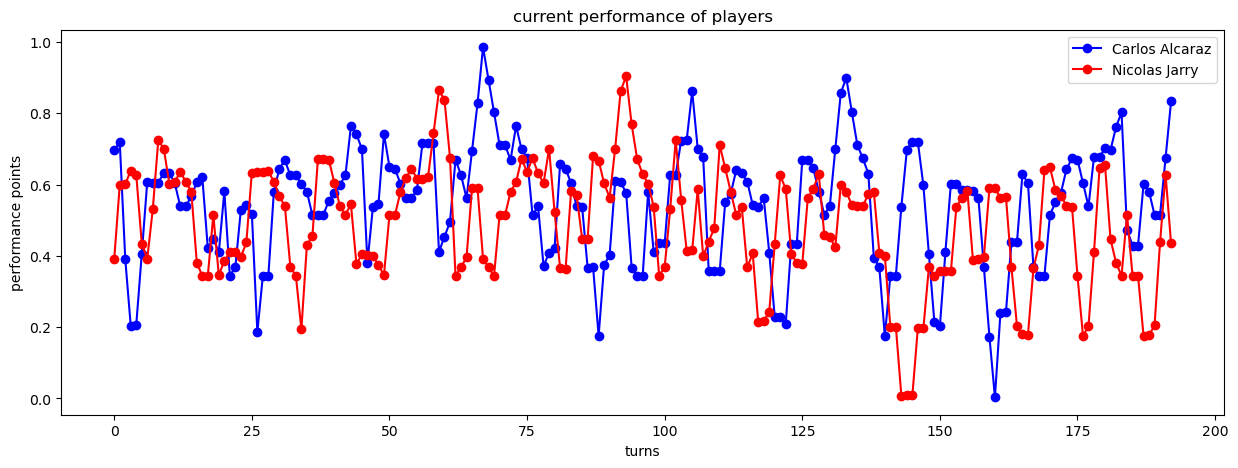

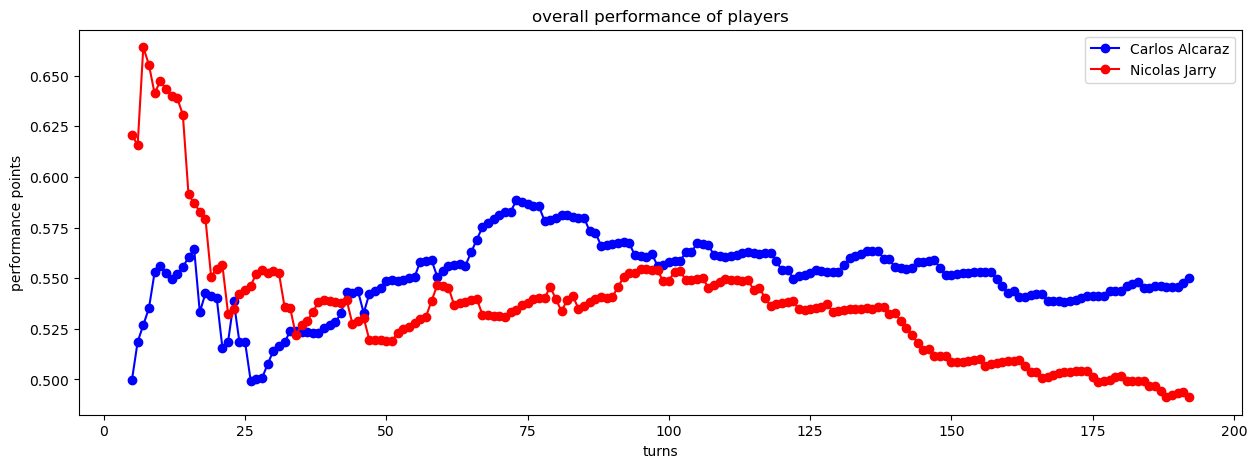

Accuracy: 0.7834
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79       217
           1       0.79      0.77      0.78       217

    accuracy                           0.78       434
   macro avg       0.78      0.78      0.78       434
weighted avg       0.78      0.78      0.78       434

[[ 0.50647744  5.51328837 -0.58968099 -6.01926683 -4.02252149  1.18317701
   0.          7.78791777  0.3429207   4.01393501 -3.67101432  0.0179305
   0.42252895  0.32299569  0.90013076]]


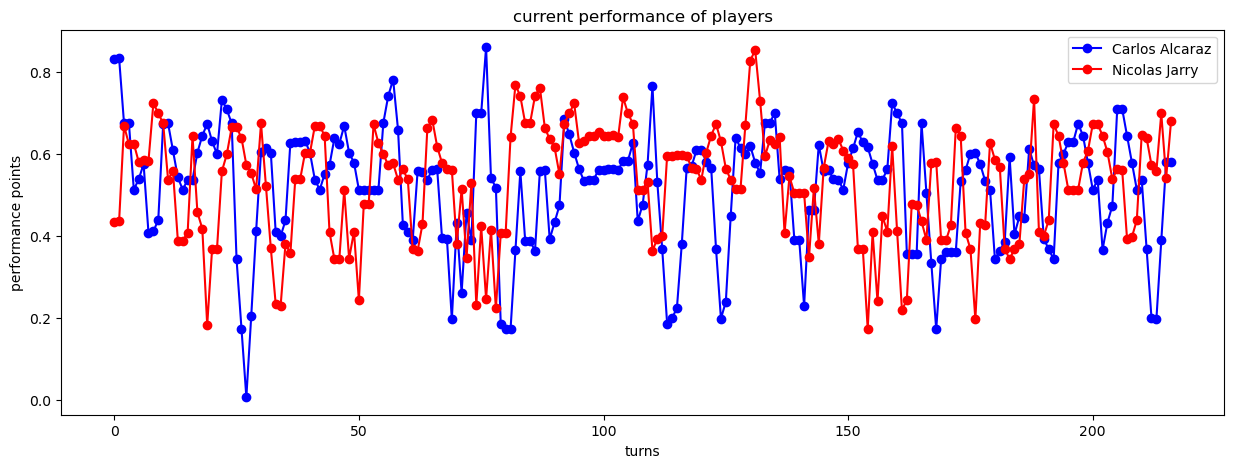

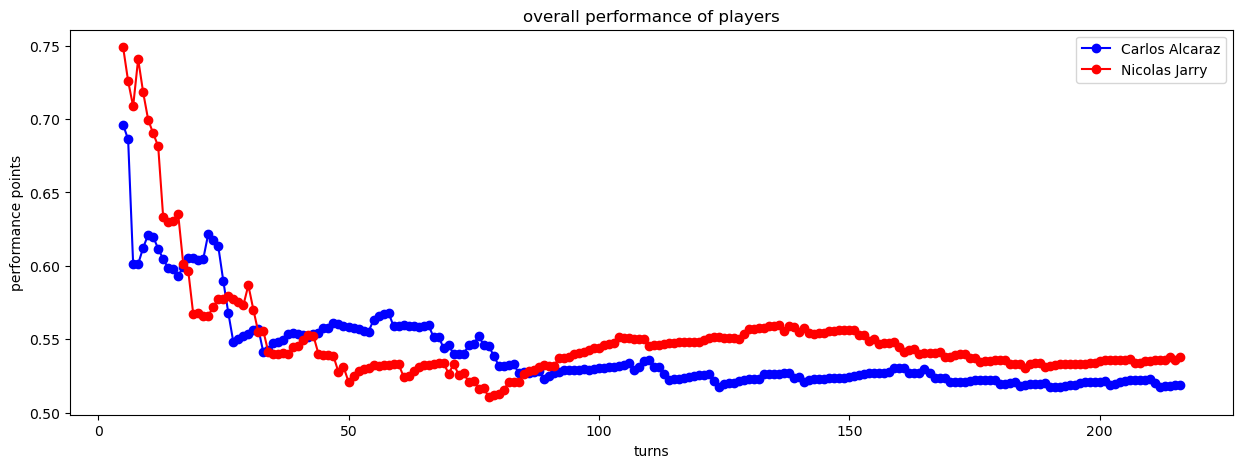

Accuracy: 0.7862
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.81      0.79       159
           1       0.80      0.77      0.78       159

    accuracy                           0.79       318
   macro avg       0.79      0.79      0.79       318
weighted avg       0.79      0.79      0.79       318

[[ 0.50543197  5.52329052 -0.58181113 -6.02445884 -4.00697153  1.18670958
   0.          7.74106523  0.33074681  4.00442378 -3.67367697  0.03715338
   0.41030308  0.31614424  0.89811216]]


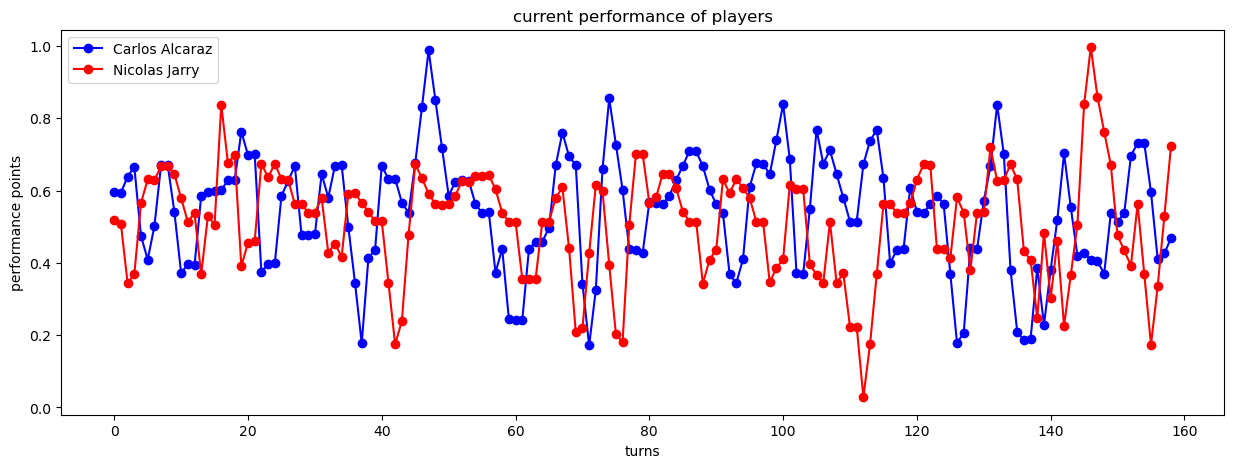

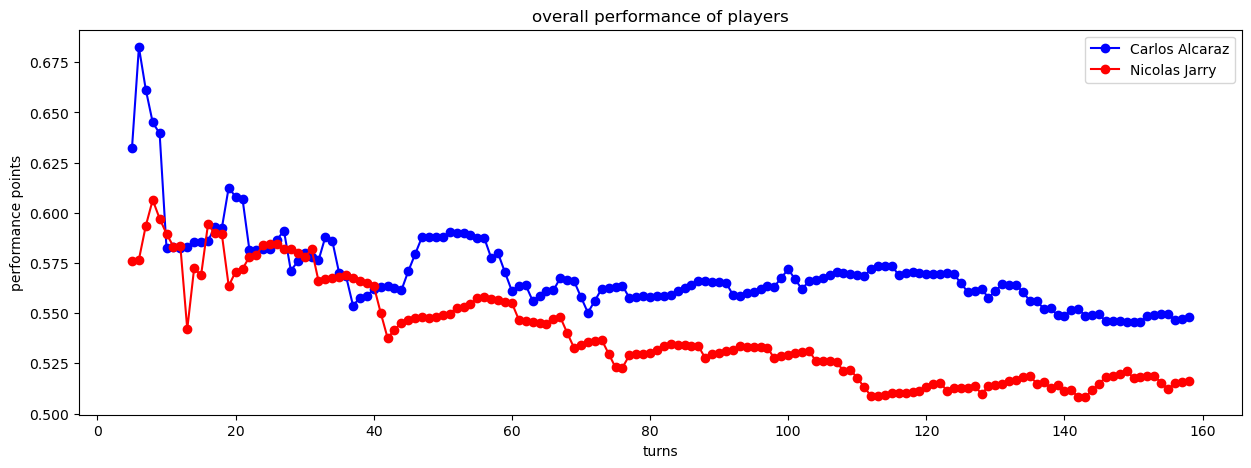

Accuracy: 0.8267
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       202
           1       0.84      0.80      0.82       202

    accuracy                           0.83       404
   macro avg       0.83      0.83      0.83       404
weighted avg       0.83      0.83      0.83       404

[[ 0.50543581  5.51302063 -0.59112889 -6.0089855  -4.00035263  1.17403161
   0.          7.7627117   0.33951693  4.02356136 -3.68404443  0.01027135
   0.41565686  0.32746966  0.89798818]]


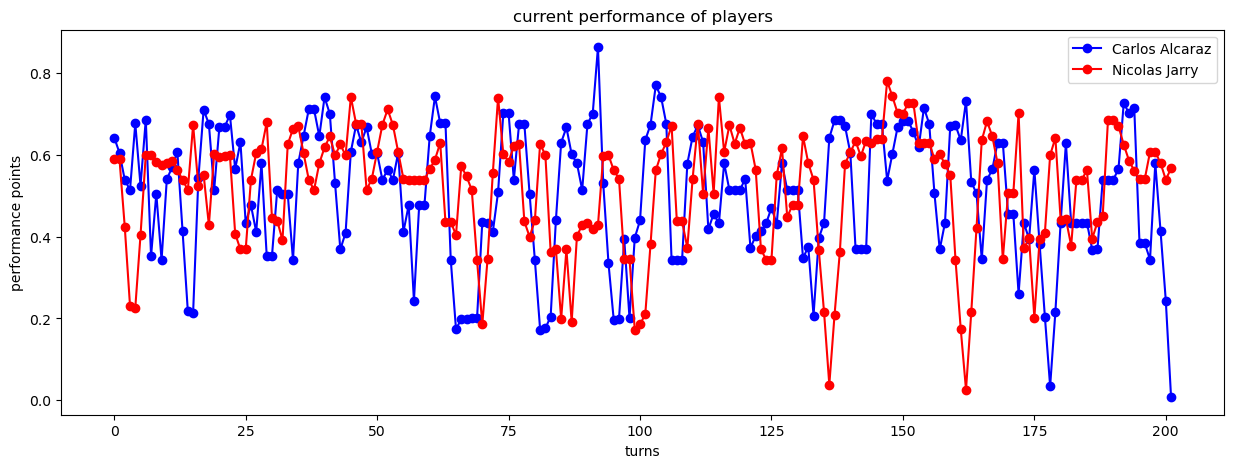

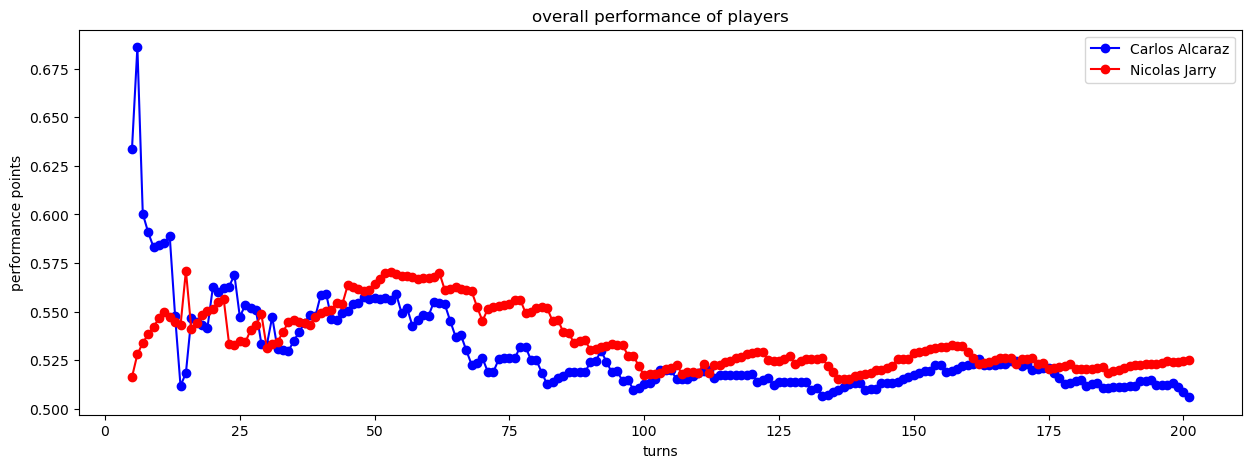

Accuracy: 0.7904
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.82      0.80       334
           1       0.81      0.76      0.78       334

    accuracy                           0.79       668
   macro avg       0.79      0.79      0.79       668
weighted avg       0.79      0.79      0.79       668

[[ 0.51458862  5.496701   -0.58256944 -6.00066442 -3.97773273  1.20167044
   0.          7.70386286  0.34767995  3.98508652 -3.63740657  0.01451152
   0.39128562  0.32723731  0.90536248]]


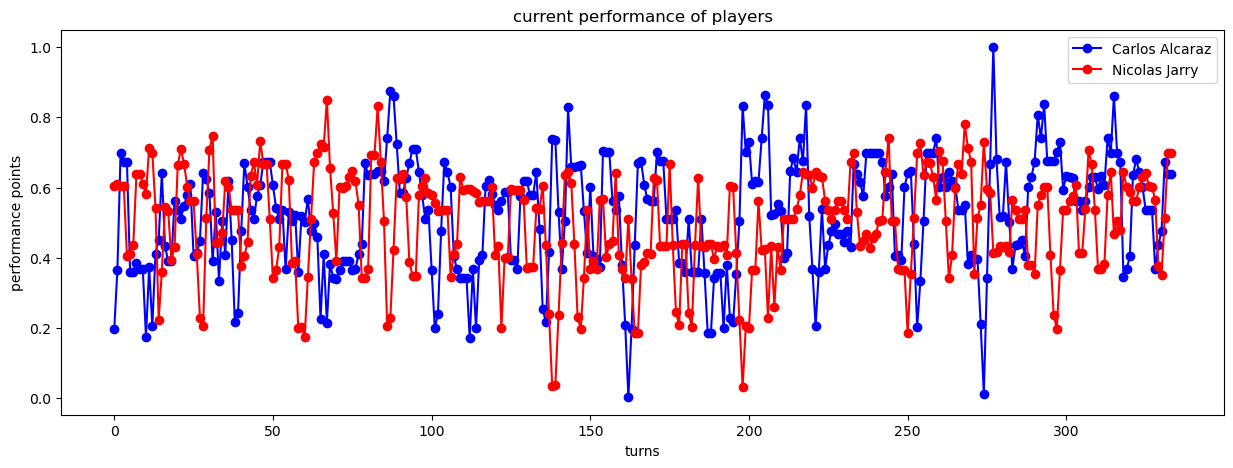

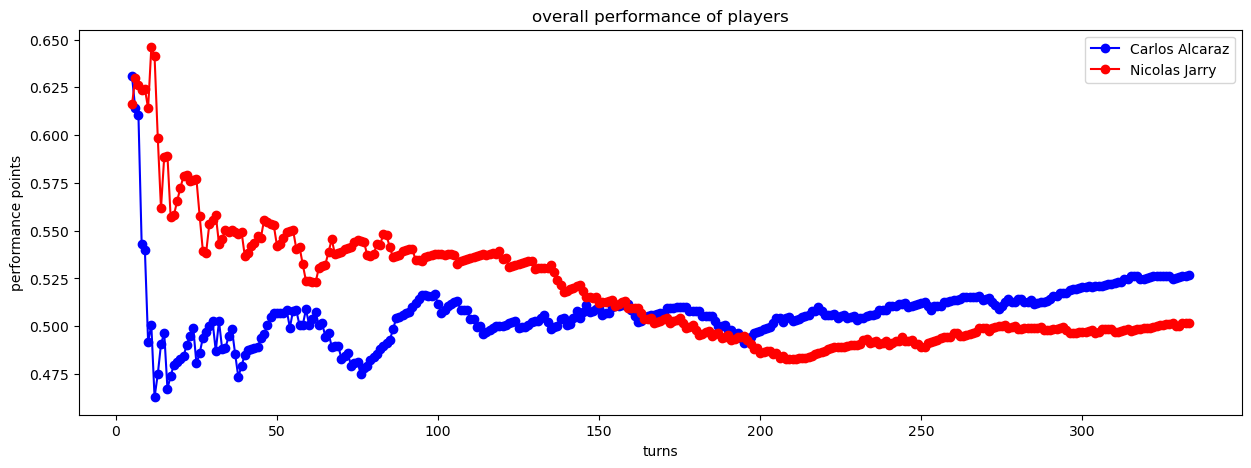

array(['0.018301607716686857', '0.31773536090508414',
       '0.2153366260009391', ..., '0.6385165204461973',
       '0.6374721688496005', '?'], dtype='<U32')

In [14]:
p1_c,p2_c,p1_o,p2_o=np.array([]),np.array([]),np.array([]),np.array([])
for i in df['match_id'].unique():
    c1,c2,o1,o2=get_csv(i)
    p1_c=np.hstack((p1_c, c1))
    p2_c=np.hstack((p2_c, c2))
    p1_o=np.hstack((p1_o, o1))
    p2_o=np.hstack((p2_o, o2))
    p1_c=np.hstack((p1_c, np.array(['?'])))
    p2_c=np.hstack((p2_c, np.array(['?'])))
    p1_o=np.hstack((p1_o, np.array(['?'])))
    p2_o=np.hstack((p2_o, np.array(['?'])))
p1_c




In [16]:
pd.DataFrame({'p1_current':p1_c,
              'p2_current':p2_c,
              'p1_overall':p1_o,
              'p2_overall':p2_o}).to_csv('performance_final.csv')

In [17]:
pd.DataFrame({'p1_current':p1_c,
              'p2_current':p2_c,
              'p1_overall':p1_o,
              'p2_overall':p2_o})

p1_current          p2_current            p1_overall  \
0     0.018301607716686857  1.0474914734391378  0.018301607716686857   
1      0.31773536090508414  0.5136021158529344    0.3223990693505626   
2       0.2153366260009391  0.5364624616531957   0.21844576496459142   
3       0.4494467292009555  0.3755162239190857   0.34166044882988833   
4       0.4777163594055836  0.3753187286297429    0.4155894433835752   
...                    ...                 ...                   ...   
7310    0.4779143784876884  0.3512599507027001    0.5259694062729101   
7311    0.6743221545606107  0.5140380539113942    0.5261930385815283   
7312    0.6385165204461973   0.699059425912677    0.5264257523861983   
7313    0.6374721688496005  0.6990423470935635    0.5269709280924612   
7314                     ?                   ?                     ?   

              p2_overall  
0     1.0474914734391378  
1     0.7805292026350754  
2     0.7144138528412897  
3     0.5435100362990988  
4     0.5374029182318759  
...                  ...  
7310  0.5000455717461554  
7311  0.5015500977820261  
7312  0.5018038307826828  
7313  0.5018329679319106  
7314                   ?  

[7315 rows x 4 columns]

In [20]:
len(df)/2+31

7315.0